## **Phase 2: Project Mid-point Check - Progress Report**

**I. Refined Project Objectives & Problem Statement**

**1. Refined Problem Statement**

Credit card fraud is a significant and escalating threat to the global financial system, causing billions in annual losses. The FTC reported that in 2024, credit card fraud was the most common form of identity theft, with over **449,000 reports**, representing an **8% increase** from the previous year.

The core challenge for building a fraud detection model is the necessity of accurately modeling a **highly imbalanced dataset**. Initial exploration of the transaction data reveals an **extremely significant class imbalance**, where fraudulent transactions constitute a very minute fraction of the total records. This renders simple **accuracy** a misleading performance metric.

Our study addresses this by:
* **Primary Goal:** Developing a robust machine learning classifier to accurately and robustly identify fraud while specifically managing the class imbalance problem.
* **Supporting Sub-Goals (Data Analysis & Feature Engineering):**
    * **Behavioral Anomaly Detection:** Analyzing customer spending patterns (frequency, typical amounts) to detect significant deviations that indicate a compromised account.
    * **Contextual Transaction Risk Analysis:** Performing feature engineering that is more indicative of fraud risk by incorporating factors like **time of day (e.g., late-night transactions), population of the city, and the typical transaction volume** of the merchant's area.
    * **Transaction Classification:** Categorizing transactions by merchant type to provide critical context for risk assessment.

**2. Problem Objectives**

The primary objective of this project is to **develop, implement, and rigorously evaluate a supervised machine learning system** capable of classifying credit card transactions as either **legitimate (non-fraudulent)** or **fraudulent** with **high reliability, particularly in the face of extreme class imbalance**.

Specifically, the system must achieve:
1.  **High Recall (Sensitivity):** Maximizing the detection of true fraudulent transactions to prevent financial loss.
2.  **High Precision:** Minimizing false positives (flagging legitimate transactions as fraud) to avoid customer inconvenience.
3.  **Advanced Modeling:** **Explore and evaluate ensemble methods (e.g., Random Forest or XGBoost)**, which are inherently more robust than single classifiers for complex, imbalanced datasets.
4.  **Comparative Analysis:** Evaluate the trade-offs of at least three classification algorithms specifically tuned and sampled for highly imbalanced data.

**Project Environment Setup and Library Imports**

This section details the necessary libraries and initial configurations for the project. The imports are grouped by their primary function (Data Handling, Modeling, Preprocessing, Evaluation, and Imbalance Handling) to ensure clarity for all team members throughout the project lifecycle.

In [3]:
# --- 1. Core Data Handling and Visualization ---
import pandas as pd # Data manipulation and analysis
import numpy as np # Numerical operations, especially for arrays
import matplotlib.pyplot as plt # Standard plotting library
import seaborn as sns # Enhanced statistical data visualization

# --- 2. Google Colab / Kaggle Tools ---
import kagglehub # Tool for easily downloading Kaggle datasets
from kagglehub import KaggleDatasetAdapter # Specific adapter for dataset access

# --- 3. Scikit-learn: Model Selection, Pipelines, and Basic Classifiers ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV # Splitting data, cross-validation
from sklearn.pipeline import Pipeline # Sequential application of transforms and estimators
from sklearn.neighbors import KNeighborsClassifier # Our first classification algorithm (K-NN)
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.base import clone # Utility for cloning estimators
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier


# --- 4. Scikit-learn: Preprocessing and Feature Engineering ---
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler # Standard scaling techniques
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # Encoding for categorical features
from sklearn.compose import ColumnTransformer # Applying different transformers to different columns
from sklearn.preprocessing import FunctionTransformer # Wrapping custom functions into scikit-learn transformers
from sklearn.decomposition import PCA # Principal Component Analysis (dimensionality reduction)
from pandas.plotting import scatter_matrix # Utility for pairwise scatter plots

import xgboost as xgb

# --- 5. Model Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, # Basic classification metrics
    precision_score, recall_score, f1_score, # Metrics critical for imbalanced data
    roc_curve, auc, precision_recall_curve, classification_report # Curve metrics and comprehensive report
)

# --- 6. Imbalance Handling (via imblearn - needed for Phase 3 but imported now) ---
# Note: These are for advanced handling of the class imbalance problem
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE # Oversampling techniques
from imblearn.under_sampling import RandomUnderSampler # Undersampling technique
# from imblearn.pipeline import make_pipeline # Special pipeline for integrating sampling steps

# --- 7. Domain-Specific (Geocoding library, currently disabled but noted) ---
# from geopy.geocoders import Nominatim # Library for converting addresses/coords (removed from analysis but kept for reference)


try:
    import google.colab
    from google.colab.data_table import DataTable # Improves display of large DataFrames in Colab
    DataTable.max_columns = 30 # Set max columns for display
    IN_COLAB = True
except:
    IN_COLAB = False

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# Load the latest version
if IN_COLAB == True:
  data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "priyamchoksi/credit-card-transactions-dataset",
    "credit_card_transactions.csv",
    # Provide any additional arguments like
    # sql_query or pandas_kwargs. See the
    # documenation for more information:
    # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  )
else:
  data = pd.read_csv('./dataset/credit_card_transactions.csv')
num_records = len(data)
features = data.keys()
num_features = len(features)
target = data['is_fraud']

print(num_records)
print(num_features)

1296675
24


# **II. Dataset Description and Evidence of Initial Exploration**

**1. Dataset and Source**

* **Dataset:** Credit Card Transactions
* **Source:** `https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset`
* **Description:** This labeled dataset has over **1.29 million records with 24 features**, including transaction times, amounts, and location data. Its large size and labeled nature make it ideal for supervised learning.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## 2. Data Information and Variable Description

The dataset, consisting of **$1,296,675$ records** across **$24$ features**, is highly detailed. An initial review of the `data.info()` output shows that most columns are fully populated, with the exception of `merch_zipcode`.

The column types are distributed as follows:
* **`float64`**: 6 columns
* **`int64`**: 6 columns
* **`object` (strings)**: 12 columns

### Variable Descriptions

| Column Name | Dtype | Description | Relevance to Fraud Detection |
| :--- | :--- | :--- | :--- |
| **0. Unnamed: 0** | `int64` | Unnamed index column (likely a residual column from CSV export). | **Low.** Should be dropped. |
| **1. trans\_date\_trans\_time** | `object` | Full timestamp of the transaction (Date and Time). | **High.** Essential for temporal analysis (time of day, day of week). |
| **2. cc\_num** | `int64` | **Credit Card Number.** Identifies the cardholder/account. | **High.** Crucial for deriving behavioral features (transaction velocity, frequency per card). |
| **3. merchant** | `object` | Name of the merchant where the transaction occurred. | **High.** Needed for fraud risk scoring and transaction categorization. |
| **4. category** | `object` | Category of the purchase (e.g., 'gas\_transport', 'grocery\_pos', 'misc\_net'). | **High.** Vital for Transaction Classification sub-goal and checking for unusual spending. |
| **5. amt** | `float64` | **Transaction Amount.** The monetary value of the purchase. | **High.** Core feature for anomaly and behavioral detection (e.g., unusually high amounts). |
| **6. first** | `object` | Cardholder's First Name. | **Low.** Potentially useful for linking to other customer data, but not directly for transaction risk. |
| **7. last** | `object` | Cardholder's Last Name. | **Low.** Same as `first`. |
| **8. gender** | `object` | Cardholder's Gender. | **Medium.** Useful for customer segmentation/profiling. |
| **9. street** | `object` | Cardholder's Street Address. | **Low.** Included in the full location data, but raw address text is typically too high-cardinality for direct use. |
| **10. city** | `object` | Cardholder's City of residence. | **Low/Medium.** Useful for local risk scoring. |
| **11. state** | `object` | Cardholder's State of residence. | **Medium.** Useful for regional fraud trend analysis. |
| **12. zip** | `int64` | Cardholder's ZIP code. | **Medium.** |
| **13. lat** | `float64` | Cardholder's residence Latitude. | **Low.** Residence location is static; only valuable for comparison with merchant location. |
| **14. long** | `float64**` | Cardholder's residence Longitude. | **Low.** Residence location is static; only valuable for comparison with merchant location. |
| **15. city\_pop** | `int64` | **Population of the cardholder's city.** | **High.** Critical feature for our **Contextual Risk Analysis** sub-goal (e.g., transactions in low-pop areas). |
| **16. job** | `object**` | Cardholder's Occupation. | **Medium.** Useful for demographic/risk profiling. |
| **17. dob** | `object**` | Cardholder's Date of Birth. | **High.** Essential for calculating **Cardholder Age** (a valuable risk feature). |
| **18. trans\_num** | `object` | **Unique Transaction Identifier.** | **Low.** Useful for indexing/tracking but not a predictive feature. |
| **19. unix\_time** | `int64` | Transaction time as Unix timestamp (seconds since epoch). | **Low.** A long number of seconds of date since 1970, which might not be helpful as much as compared to the previous column for transaction date and time. |
| **20. merch\_lat** | `float64` | Merchant's location Latitude. | **Low.** Zipcode would be more indicative to cover areas of risk. |
| **21. merch\_long** | `float64**` | Merchant's location Longitude. | **Low.** Zipcode would be more indicative to cover areas of risk. |
| **22. is\_fraud** | `int64` | **TARGET VARIABLE.** $1$ = Fraudulent, $0$ = Legitimate. | **Highest.** The classification goal. |
| **23. merch\_zipcode** | `float64` | Merchant's ZIP code. (**195,973 missing values**) | **Medium.** Can be used for localized risk scoring after imputation/handling of missing data. |

In [6]:
data[data['is_fraud'] == True].head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,...,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1,28644.0
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,...,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1,78055.0
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,...,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1,78039.0
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,...,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1,28777.0
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,...,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1,78006.0


<Axes: >

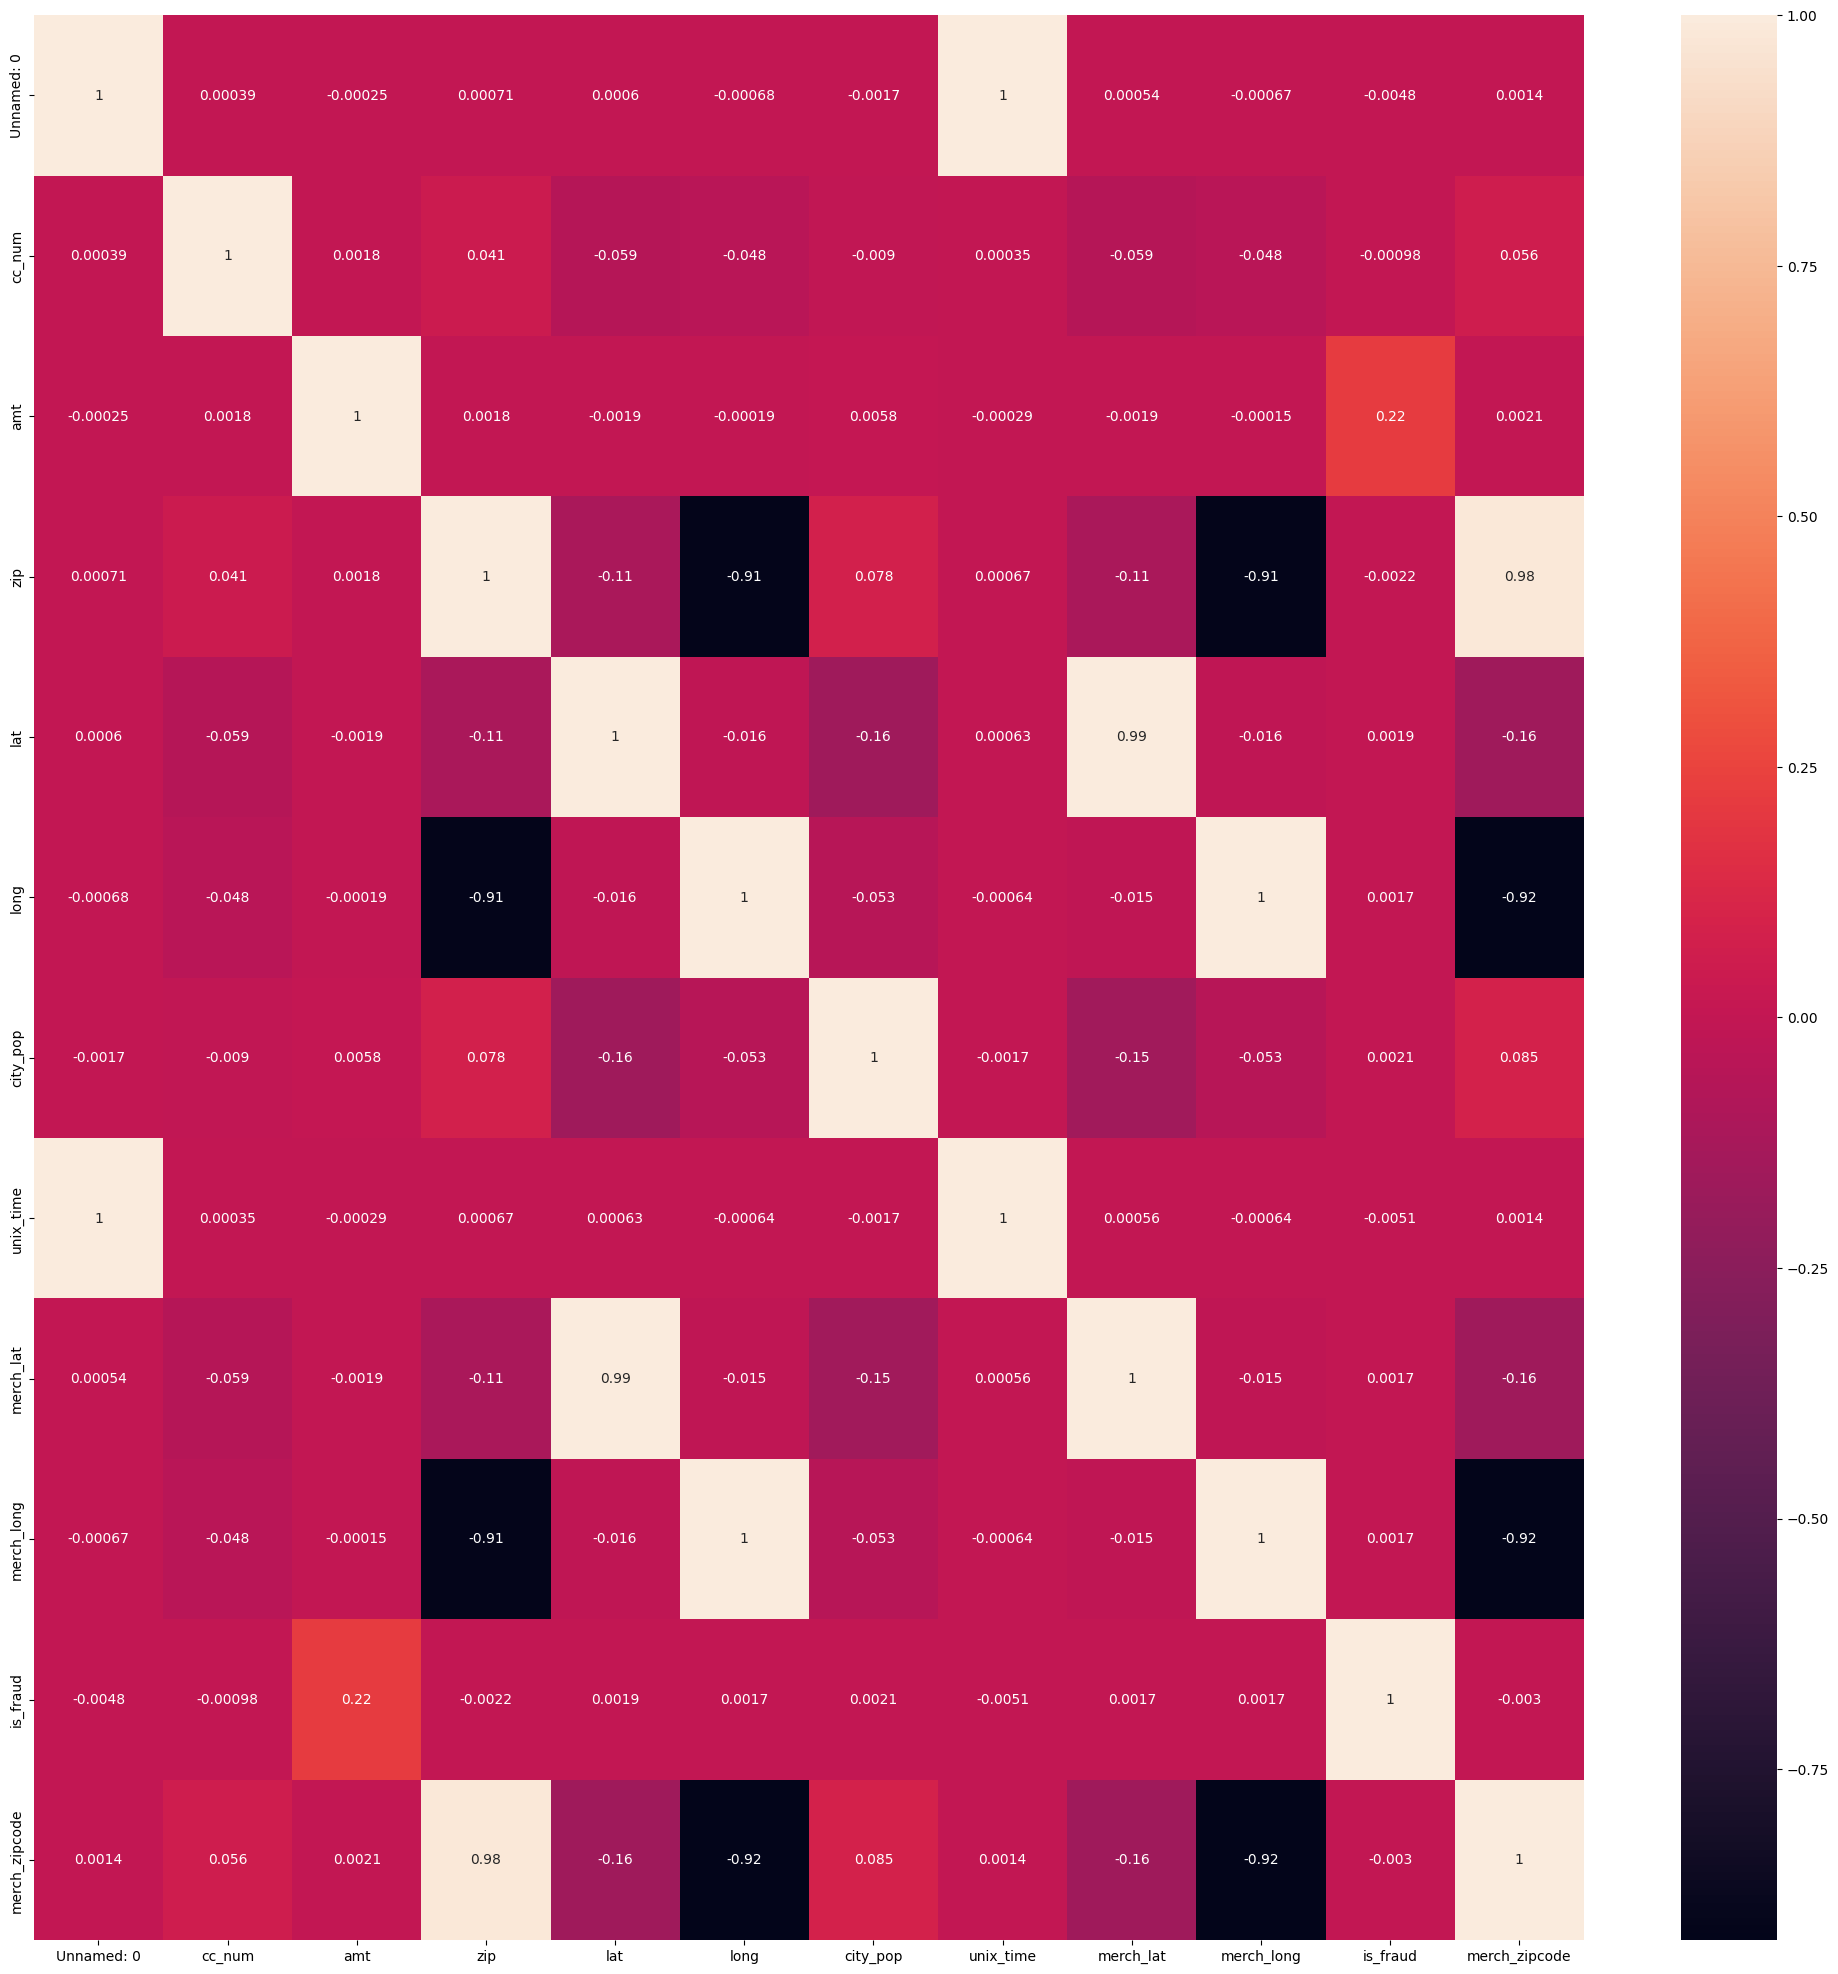

In [7]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(numeric_only=True),annot= True)

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64


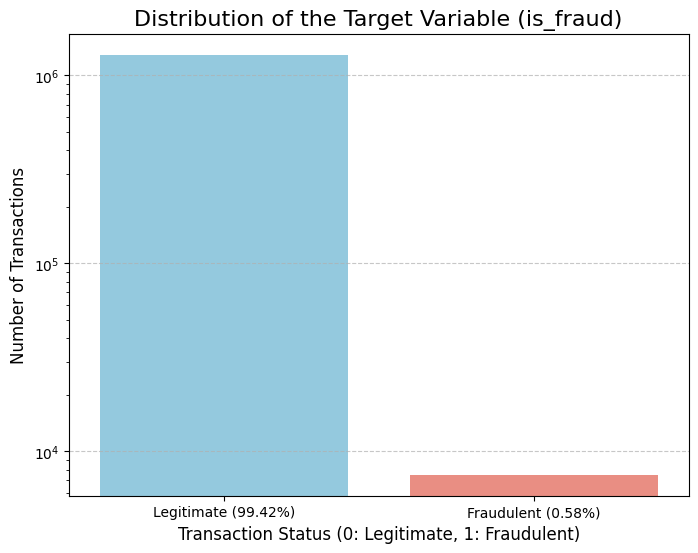

In [8]:
print(target.value_counts(normalize=True) *100)

# Create a count plot to visualize the imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=data, palette=['skyblue', 'salmon'])
plt.title('Distribution of the Target Variable (is_fraud)', fontsize=16)
plt.xlabel('Transaction Status (0: Legitimate, 1: Fraudulent)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Legitimate (99.42%)', 'Fraudulent (0.58%)'])
plt.yscale('log') # Use a log scale on the Y-axis to visualize the minority class
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Analysis of Class Imbalance (Target Variable)

The analysis of the target variable, is_fraud, confirms the severe challenge of class imbalance in our dataset, as noted in the problem statement. This is a critical factor influencing our entire modeling approach.

**Key Findings and Implications:**

1. Legitimate Transactions (Class 0): Account for 99.42% of all records.

2. Fraudulent Transactions (Class 1): Account for only 0.58% of all records.

3. This means that for every 1000 transactions, fewer than 6 are fraudulent.

This imbalance confirms that simple Accuracy is misleading. A trivial model that always predicts "Not Fraud" would achieve an accuracy of 99.42%, yet would be completely useless in a real-world application (Recall of 0%). We must therefore prioritize Precision, Recall, F1-Score, and the PR-AUC (Area Under the Precision-Recall Curve).

# **III. Progress on preprocessing steps completed so far**

This section covers the initial data cleaning, transformation, and feature engineering necessary to prepare the dataset for machine learning models. We focus on transforming time-related fields into usable numerical features and handling the high-cardinality categorical data using an **OrdinalEncoder** as well scaling for high numeric features.

In [9]:
processed_data = data.copy()
processed_data['trans_date_trans_time'] = pd.to_datetime(processed_data['trans_date_trans_time'])
processed_data['date'] = processed_data['trans_date_trans_time'].dt.date
processed_data['day_of_week'] = processed_data['trans_date_trans_time'].dt.dayofweek + 1
processed_data['month'] = processed_data['trans_date_trans_time'].dt.month
processed_data['hour_of_day'] = processed_data['trans_date_trans_time'].dt.hour + 1
processed_data['dob'] = pd.to_datetime(processed_data['dob'])
processed_data['age'] = processed_data['trans_date_trans_time'] - processed_data['dob']
processed_data['age'] = processed_data['age'].apply(lambda x: (x.days/365)).astype(int)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].fillna(0)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].astype(int)
processed_data['gender'] = processed_data['gender'].map({'M':1, 'F':0})

In [10]:
processed_data['num_of_tx_day'] = (processed_data.groupby(['cc_num','date'])['cc_num'].transform('count'))

In [11]:
processed_data.sort_values(['date','cc_num'])

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_lat,merch_long,is_fraud,merch_zipcode,date,day_of_week,month,hour_of_day,age,num_of_tx_day
1017,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,0,9886 Anita Drive,...,43.974711,-109.741904,0,0,2019-01-01,2,1,13,32,1
516,516,2019-01-01 06:48:36,60423098130,fraud_Kuphal-Predovic,misc_net,5.68,Jason,Gray,1,875 Amy Point,...,36.742499,-99.029250,0,73842,2019-01-01,2,1,7,60,2
1741,1741,2019-01-01 18:25:28,60423098130,fraud_Shanahan-Lehner,personal_care,24.77,Jason,Gray,1,875 Amy Point,...,36.068128,-98.762992,0,0,2019-01-01,2,1,19,60,2
586,586,2019-01-01 07:36:27,60427851591,fraud_Kiehn Inc,grocery_pos,78.80,Bradley,Martinez,1,3426 David Divide Suite 717,...,35.081835,-99.764056,0,0,2019-01-01,2,1,8,42,1
984,984,2019-01-01 12:31:09,60490596305,fraud_Beier LLC,entertainment,87.07,Karen,Johnson,0,4349 Anna Flat Suite 214,...,34.446626,-90.840089,0,72366,2019-01-01,2,1,13,55,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295619,1295619,2020-06-21 03:03:27,4989847570577635369,fraud_Bailey-Morar,grocery_pos,188.02,Vanessa,Anderson,0,21178 Brittney Locks,...,35.026104,-80.728020,0,28104,2020-06-21,7,6,4,25,1
1295369,1295369,2020-06-21 00:41:01,4992346398065154184,fraud_Bernhard Inc,gas_transport,74.29,Benjamin,Kim,1,920 Patrick Light,...,40.743634,-89.553379,0,61616,2020-06-21,7,6,1,64,4
1295587,1295587,2020-06-21 02:47:59,4992346398065154184,"fraud_Reichert, Rowe and Mraz",shopping_net,246.56,Benjamin,Kim,1,920 Patrick Light,...,40.215418,-88.682562,0,61842,2020-06-21,7,6,3,64,4
1296206,1296206,2020-06-21 08:04:28,4992346398065154184,fraud_Jewess LLC,shopping_pos,2.62,Benjamin,Kim,1,920 Patrick Light,...,40.762861,-88.744967,0,61726,2020-06-21,7,6,9,64,4


### 1. Feature Engineering Steps

The following steps were executed:

1.  **Temporal Feature Extraction:**
    * `trans_date_trans_time` and `dob` were converted to datetime objects.
    * New features `day_of_week`, `month`, and `hour_of_day` were extracted from the transaction timestamp.
2.  **Age Calculation:** The `age` of the cardholder was calculated from `dob` and the transaction time, converted to an integer (years).
3.  **Missing Value Imputation:** Missing values in `merch_zipcode` were imputed with 0, and the column type was set to integer.
4.  **Binary Encoding:** The `gender` column was mapped to numerical values (`M`: 1, `F`: 0).
5.  **Feature Selection:** Irrelevant identifiers, redundant columns, and raw geospatial coordinates (as per the refined problem statement due to data quality concerns) were prepared for dropping.

In [12]:
cat_col = ['cc_num','category','job', 'merch_zipcode', 'merchant']
drop_col = ['Unnamed: 0','trans_num','first','last','dob',
            'street','city'
            ,'lat','long','unix_time','merch_lat','merch_long', 'trans_date_trans_time']
scale_col = ['amt', 'city_pop']
ct_processing = ColumnTransformer([
        ('cat', OrdinalEncoder(),cat_col),
        ('scale', StandardScaler(), scale_col),
        ('drop','drop',drop_col),
        ], remainder='passthrough')
ct_processing.set_output(transform='pandas')
processed_data = ct_processing.fit_transform(processed_data)
for col in processed_data.columns:
  processed_data.rename(columns={col:col.replace('remainder__','')}, inplace=True)


### 2. Column Transformation Pipeline

A **`ColumnTransformer`** is utilized to apply disparate preprocessing steps concurrently across different groups of features, ensuring a clean and consistent data pipeline for modeling.

| Action | Columns | Justification |
| :--- | :--- | :--- |
| **`OrdinalEncoder`** | `cc_num`, `category`, `job`, `merch_zipcode`, `zip`, `merchant` | Applied to **high-cardinality categorical features**. While this imposes an arbitrary order, it is a fast and simple approach for **initial model benchmarking**, especially given the memory constraints of **One-Hot Encoding** on such a large dataset ($\sim1.3$M records). |
| **`StandardScaler`** | `amt`, `city_pop` | Applied to continuous numerical features for **normalization**. This ensures features with large scales (like $\text{city\_pop}$ or $\text{amt}$) do not disproportionately influence distance-based or gradient-based models. |
| **`Drop`** | $14$ columns (e.g., $\text{lat}$, $\text{long}$, $\text{dob}$, $\text{street}$) | Irrelevant/redundant columns, including raw geospatial coordinates (as removed in objective refinement), are dropped. |

The remaining features (`gender`, `is_fraud`, `day_of_week`, `month`, `hour_of_day`, `age`) are passed through unaltered (`remainder='passthrough'`).

In [13]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   cat__cc_num         1296675 non-null  float64
 1   cat__category       1296675 non-null  float64
 2   cat__job            1296675 non-null  float64
 3   cat__merch_zipcode  1296675 non-null  float64
 4   cat__merchant       1296675 non-null  float64
 5   scale__amt          1296675 non-null  float64
 6   scale__city_pop     1296675 non-null  float64
 7   gender              1296675 non-null  int64  
 8   state               1296675 non-null  object 
 9   zip                 1296675 non-null  int64  
 10  is_fraud            1296675 non-null  int64  
 11  date                1296675 non-null  object 
 12  day_of_week         1296675 non-null  int32  
 13  month               1296675 non-null  int32  
 14  hour_of_day         1296675 non-null  int32  
 15  age            

### 2. Final Feature Set (data.info() Output)

The final dataset, after transformation, is clean, fully numerical, and has a reduced memory footprint.

Plot 1: Fraud Count by Gender


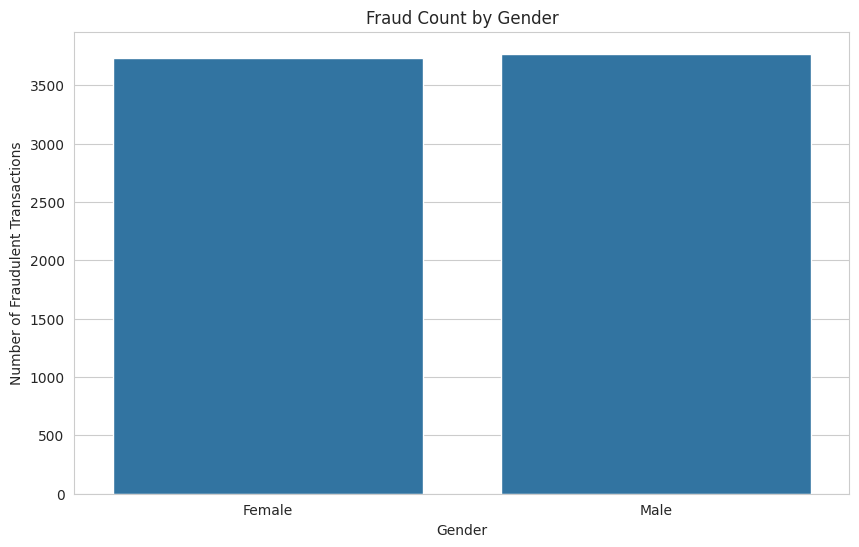

In [14]:
# Filter for fraudulent transactions
fraud_data = processed_data[processed_data['is_fraud'] == 1].copy()

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# --- Plot 1: Gender with fraud count ---
print("Plot 1: Fraud Count by Gender")
sns.countplot(x='gender', data=fraud_data)
plt.title('Fraud Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()


Plot 2: Fraud Count by Hour of Day


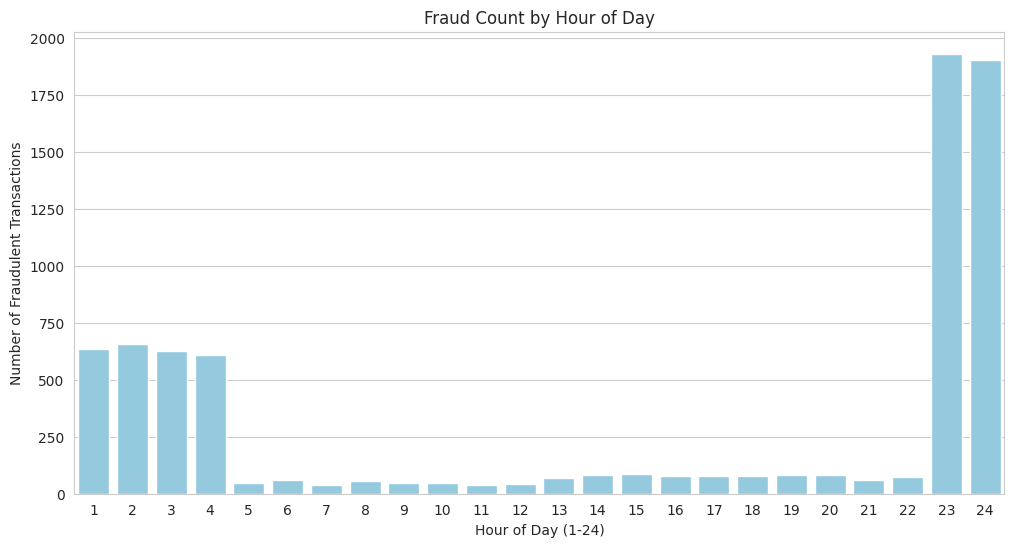

In [15]:
print("\nPlot 2: Fraud Count by Hour of Day")
plt.figure(figsize=(12, 6))
sns.countplot(x='hour_of_day', data=fraud_data, color='skyblue', order=sorted(fraud_data['hour_of_day'].unique()))
plt.title('Fraud Count by Hour of Day')
plt.xlabel('Hour of Day (1-24)')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


Plot 3: Fraud Count by Day of Week


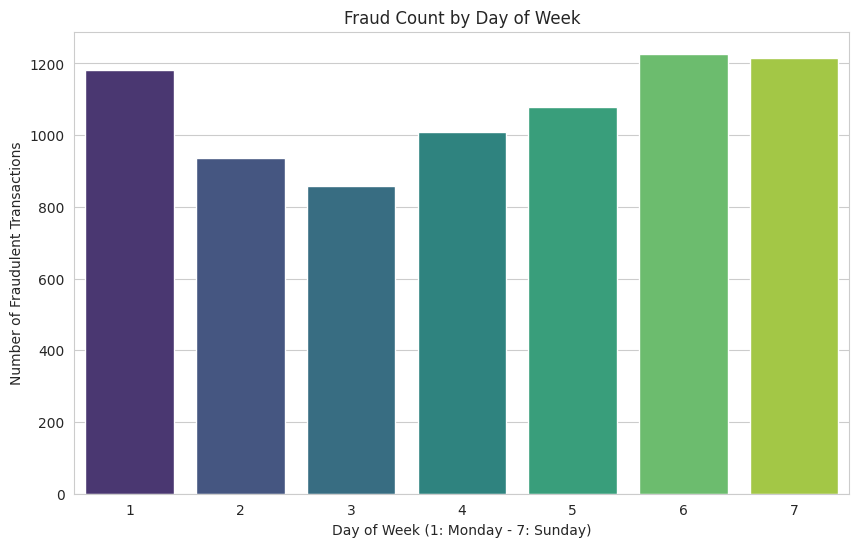

In [16]:
print("\nPlot 3: Fraud Count by Day of Week")
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=fraud_data, palette='viridis', order=sorted(fraud_data['day_of_week'].unique()))
plt.title('Fraud Count by Day of Week')
plt.xlabel('Day of Week (1: Monday - 7: Sunday)')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


Plot 4: Top 20 Encoded Credit Cards by Fraud Count


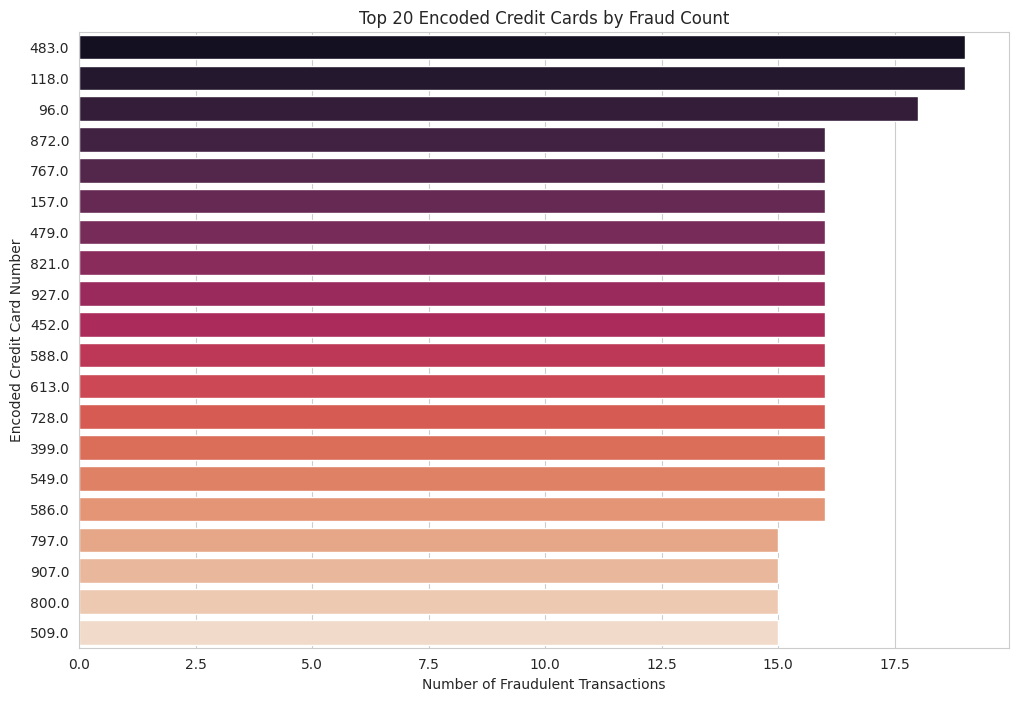

In [17]:
print("\nPlot 4: Top 20 Encoded Credit Cards by Fraud Count")
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['cat__cc_num'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 Encoded Credit Cards by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Encoded Credit Card Number')
plt.show()


Plot 5: Fraud Count by Scaled Amount Interval


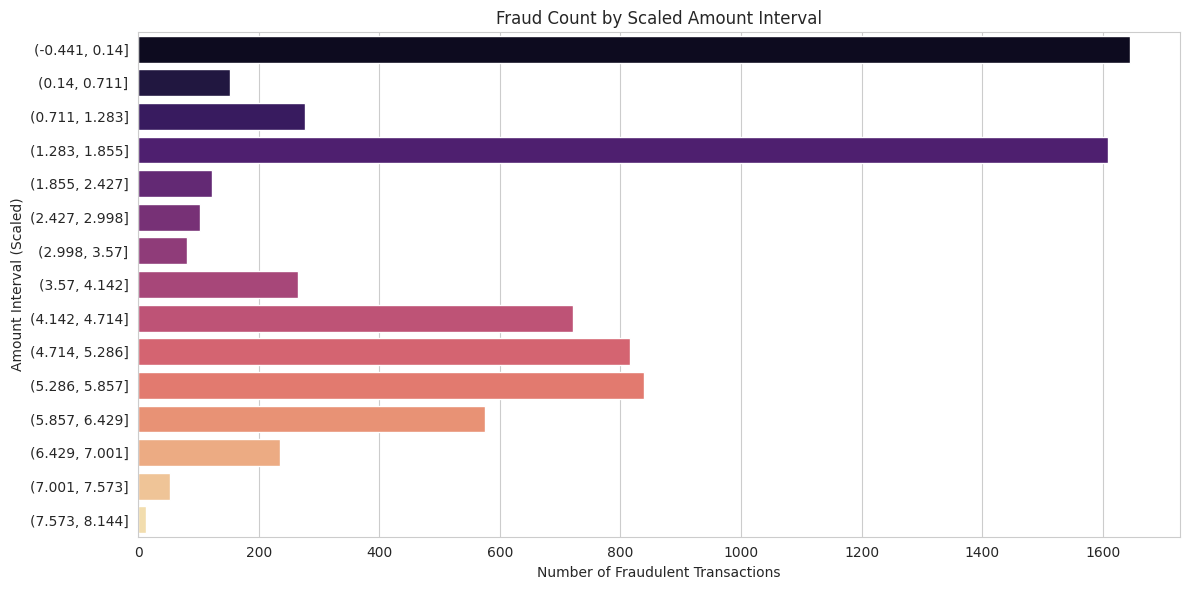

In [18]:
print("\nPlot 5: Fraud Count by Scaled Amount Interval")
plt.figure(figsize=(12, 6))
fraud_data['amt_interval'] = pd.cut(fraud_data['scale__amt'], bins=15)
sns.countplot(data=fraud_data, y='amt_interval', palette='magma', orient='h')
plt.title('Fraud Count by Scaled Amount Interval')
plt.ylabel('Amount Interval (Scaled)')
plt.xlabel('Number of Fraudulent Transactions')
plt.tight_layout()
plt.show()


Plot 6: Fraud Count by Age Group


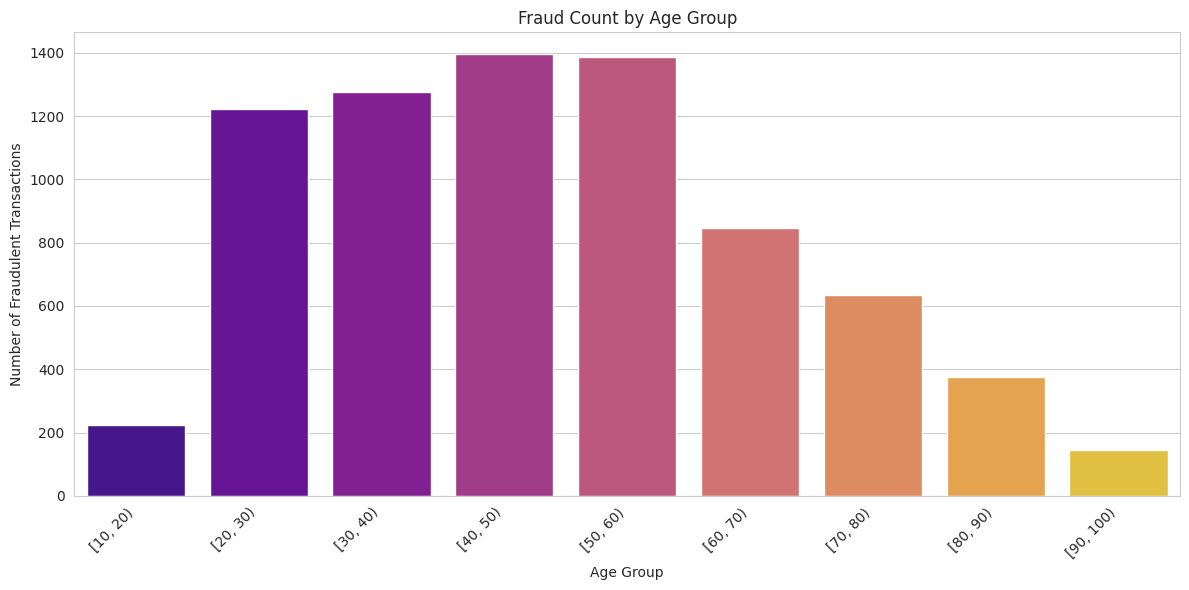

In [19]:
print("\nPlot 6: Fraud Count by Age Group")
plt.figure(figsize=(12, 6))
fraud_data['age_interval'] = pd.cut(fraud_data['age'], bins=range(10, 101, 10), right=False)
sns.countplot(data=fraud_data, x='age_interval', palette='plasma')
plt.title('Fraud Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Plot 7: Fraud Count by City Population Interval


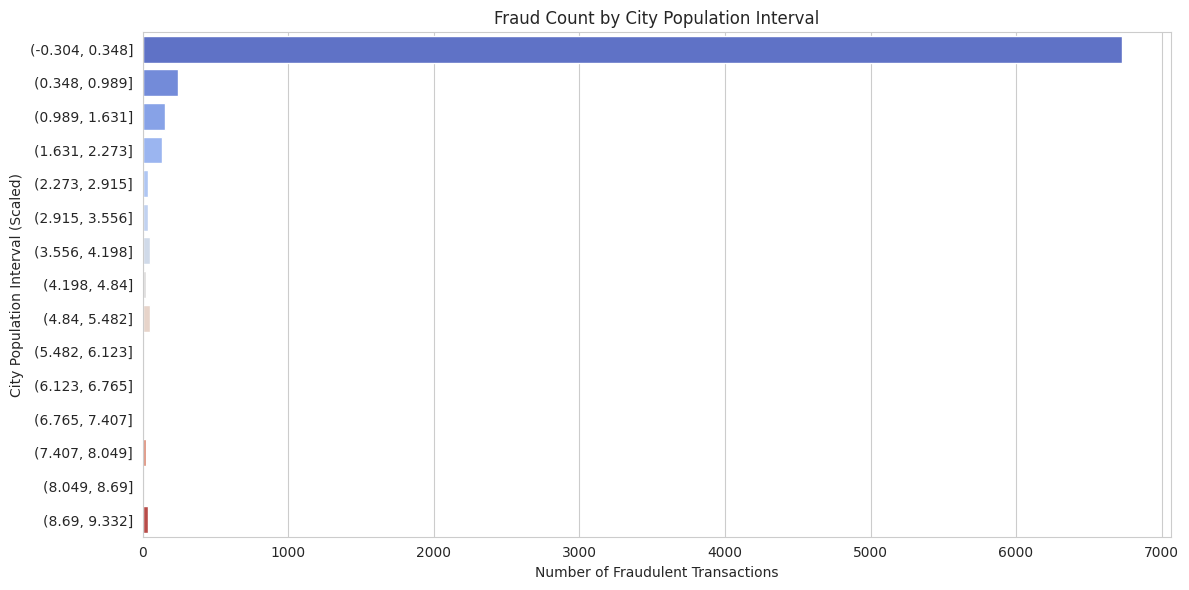

In [20]:
print("\nPlot 7: Fraud Count by City Population Interval")
plt.figure(figsize=(12, 6))
fraud_data['pop_interval'] = pd.cut(fraud_data['scale__city_pop'], bins=15)
sns.countplot(data=fraud_data, y='pop_interval', palette='coolwarm', orient='h')
plt.title('Fraud Count by City Population Interval')
plt.ylabel('City Population Interval (Scaled)')
plt.xlabel('Number of Fraudulent Transactions')
plt.tight_layout()
plt.show()


Plot 8: Top 20 State by Fraud Count


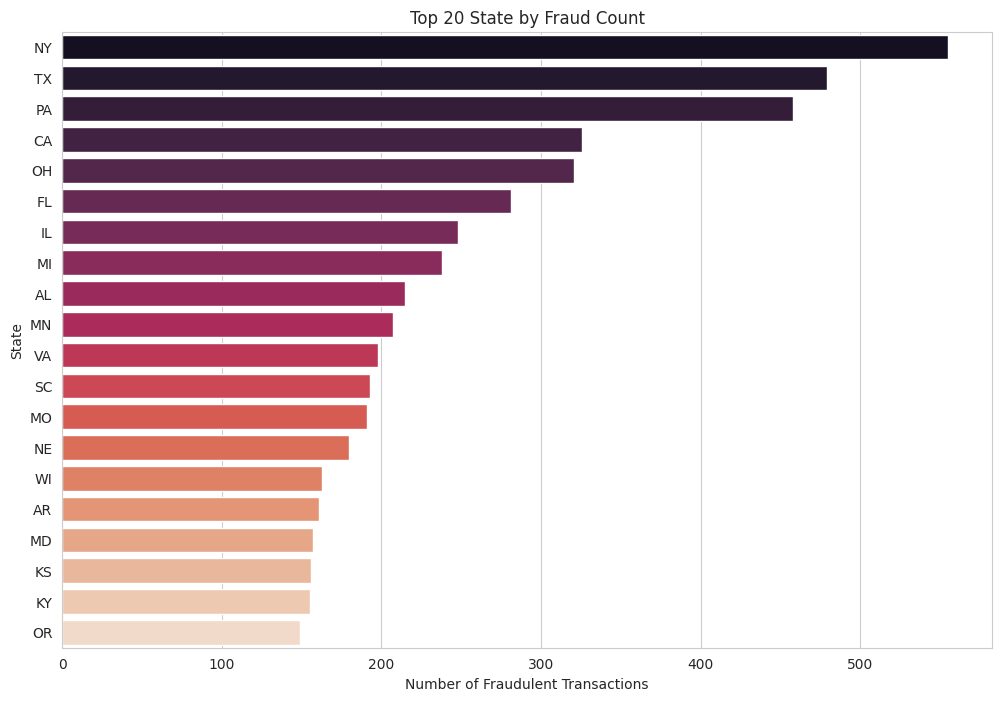

In [21]:
print("\nPlot 8: Top 20 State by Fraud Count")
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['state'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 State by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('State')
plt.show()


Plot 9-A: Top 20 Zip by Fraud Count
697


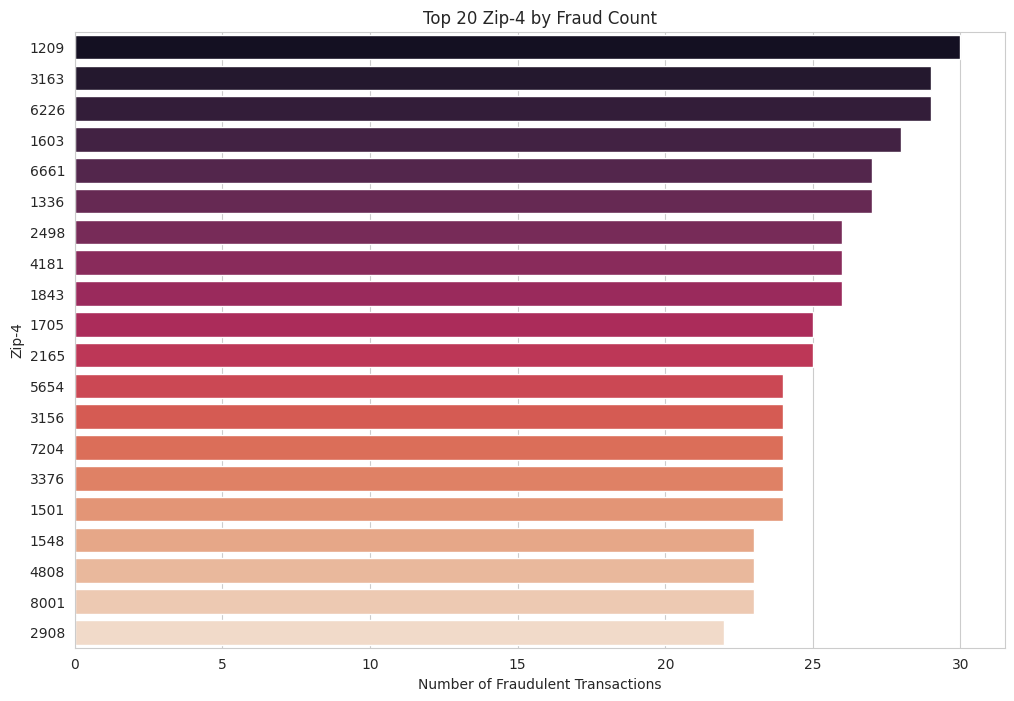

In [22]:
print("\nPlot 9-A: Top 20 Zip by Fraud Count")
fraud_data['zip_4_digit_prefix'] = fraud_data['zip'].astype(int).astype(str).str[:4]
print(len(set(fraud_data['zip_4_digit_prefix'])))
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['zip_4_digit_prefix'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 Zip-4 by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Zip-4')
plt.show()


Plot 9-B: Top 20 Zip by Fraud Count
441


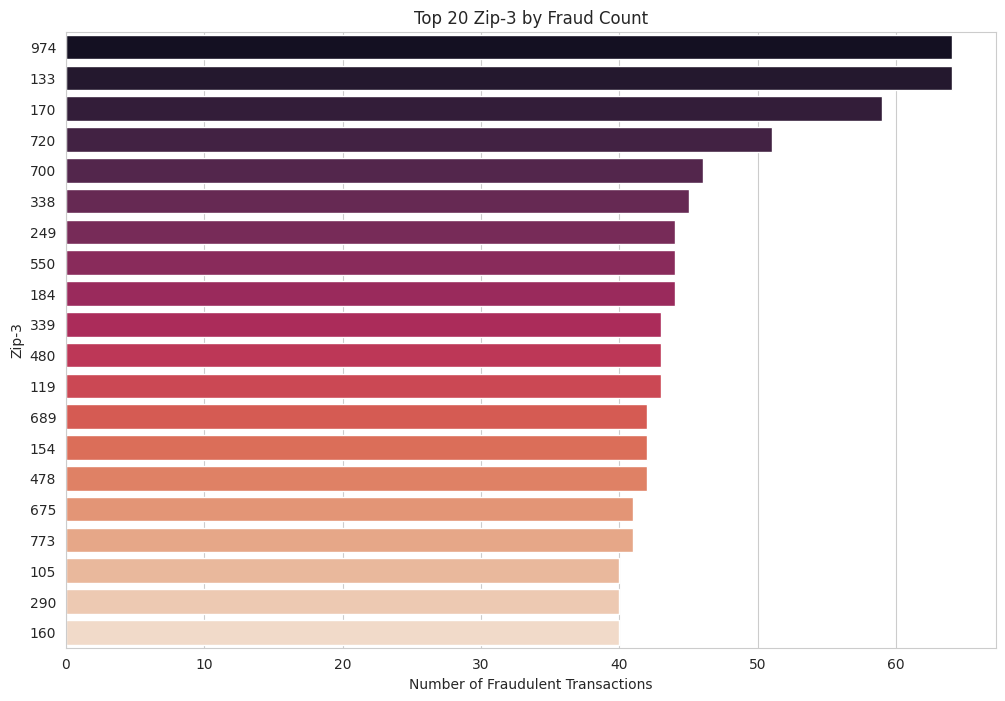

In [23]:
print("\nPlot 9-B: Top 20 Zip by Fraud Count")
fraud_data['zip_3_digit_prefix'] = fraud_data['zip'].astype(int).astype(str).str[:3]
print(len(set(fraud_data['zip_3_digit_prefix'])))
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['zip_3_digit_prefix'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 Zip-3 by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Zip-3')
plt.show()


Plot 10: Top 20 Categories by Fraud Count


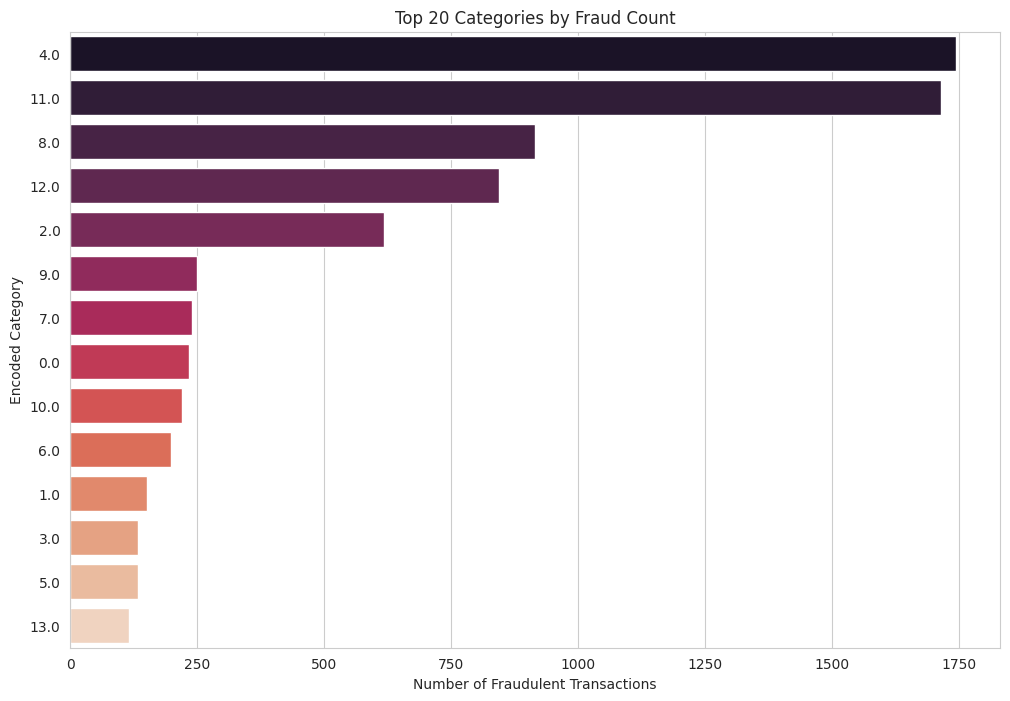

In [24]:
print("\nPlot 10: Top 20 Categories by Fraud Count")
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['cat__category'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 Categories by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Encoded Category')
plt.show()


Plot 11: Top 20 Jobs by Fraud Count


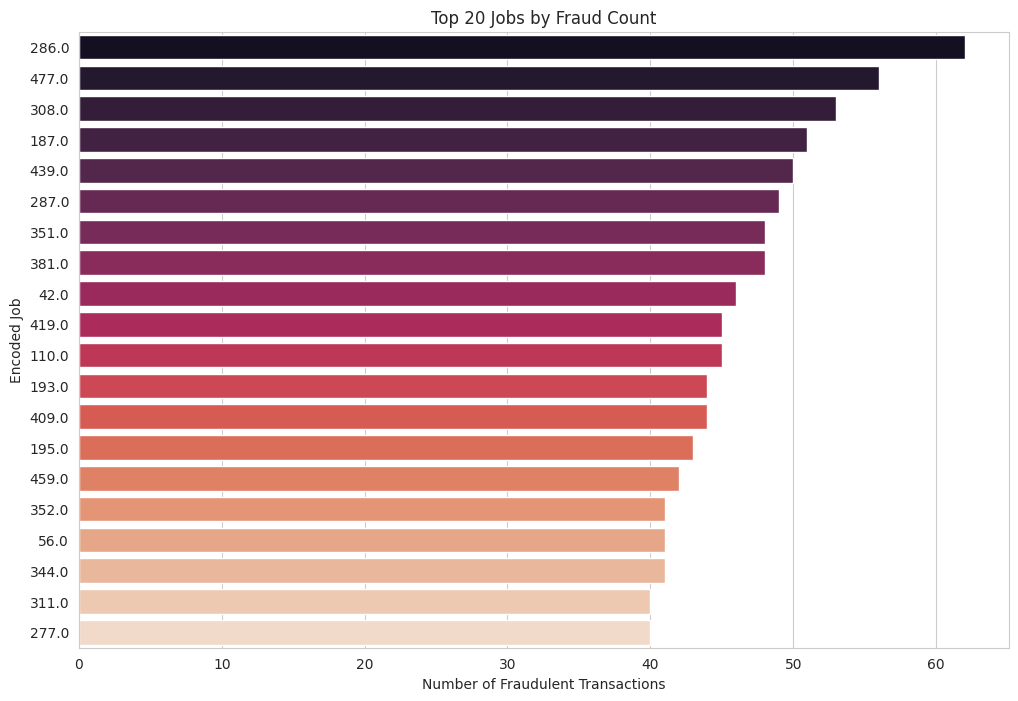

In [25]:
print("\nPlot 11: Top 20 Jobs by Fraud Count")
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['cat__job'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 Jobs by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Encoded Job')
plt.show()


Plot 11: Top 20 Merchants by Fraud Count


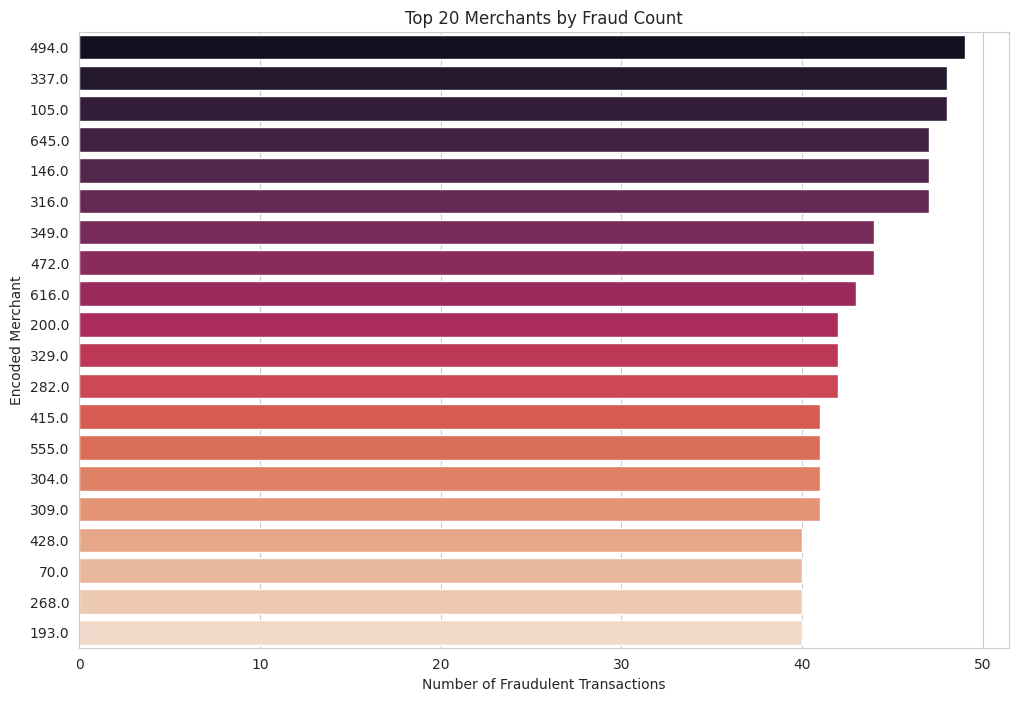

In [26]:
print("\nPlot 11: Top 20 Merchants by Fraud Count")
plt.figure(figsize=(12, 8))
top_20_cc_fraud = fraud_data['cat__merchant'].value_counts().nlargest(20)
sns.barplot(x=top_20_cc_fraud.values, y=top_20_cc_fraud.index.astype(str), orient='h', palette='rocket')
plt.title('Top 20 Merchants by Fraud Count')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Encoded Merchant')
plt.show()

## Justification for Dropping Location Features

Based on the preliminary analysis performed on the raw ZIP code data, we determined that the original geospatial features were not suitable for direct use in the model, leading to their exclusion from the final preprocessing pipeline:

**Inconclusive Evidence from Grouping**: While we explored grouping the raw zip code by its first 3 and 4 digits (as a proxy for regional risk scoring), the resulting fraud count distributions did not yield sufficiently strong or conclusive patterns to justify the complexity of retaining the feature.

**High Volume of Null Records**: The original data.info() revealed a significant data quality issue: the $\text{merch\_zipcode}$ column contained a high number of null records. Retaining this feature would necessitate heavy imputation (introducing significant bias) or result in the exclusion of a large portion of data from modeling.

**Strategic Feature Pivot & Geographic Conclusion**: We strategically pivoted our focus from the raw, static location features to more reliable, engineered contextual features that were fully populated. Notably, the analyses of the $\text{state}$ and $\text{city_pop}$ features indicated a clear and promising signal for fraudulent rate, allowing for good geographic-based classification potential later.

Therefore, the original zip and merch\_zipcode columns were dropped from the final feature set.

In [27]:
drop_col = ['cat__merch_zipcode', 'zip']
scale_col = ['amt', 'city_pop']
ct_processing = ColumnTransformer([
        ('drop','drop',drop_col),
        ], remainder='passthrough')
ct_processing.set_output(transform='pandas')
processed_data = ct_processing.fit_transform(processed_data)
for col in processed_data.columns:
  processed_data.rename(columns={col:col.replace('remainder__','')}, inplace=True)
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   cat__cc_num      1296675 non-null  float64
 1   cat__category    1296675 non-null  float64
 2   cat__job         1296675 non-null  float64
 3   cat__merchant    1296675 non-null  float64
 4   scale__amt       1296675 non-null  float64
 5   scale__city_pop  1296675 non-null  float64
 6   gender           1296675 non-null  int64  
 7   state            1296675 non-null  object 
 8   is_fraud         1296675 non-null  int64  
 9   date             1296675 non-null  object 
 10  day_of_week      1296675 non-null  int32  
 11  month            1296675 non-null  int32  
 12  hour_of_day      1296675 non-null  int32  
 13  age              1296675 non-null  int64  
 14  num_of_tx_day    1296675 non-null  int64  
dtypes: float64(6), int32(3), int64(4), object(2)
memory usage: 133.6+ 

## IV. Machine Learning Algorithms (3+ Planned)

Our main approach is **supervised classification**. Recognizing the severe **class imbalance** ($\mathbf{0.58\%}$ fraud rate), we plan to implement and compare the performance of several algorithms, focusing on their suitability for high-dimensional, imbalanced data.

| Algorithm | Justification for Selection |
| :--- | :--- |
| **1. Logistic Regression (LR)** | **Baseline & Interpretability:** As a simple, linear model, LR is fast to train and highly interpretable. It establishes a necessary performance **benchmark** against which all subsequent, more complex models will be measured. It can also be easily modified using **class weights** to specifically address the data imbalance. |
| **2. K-Nearest Neighbors (KNN)** | **Non-Linear Pattern Recognition:** KNN is a non-parametric, distance-based model. It is well-suited for identifying fraud because it can flag a new transaction as fraudulent if it is geographically or contextually **close to known fraud events** in the feature space, without assuming a linear boundary. |
| **3. Support Vector Machines (SVM)** | **Effective in High Dimensions:** SVMs are powerful classifiers that work well by finding the optimal hyperplane to separate classes. Using a kernel trick, SVMs can effectively model **complex, non-linear relationships** often present in transaction data, providing a strong contrast to the linear performance of LR. |
| **4. Ensemble Method (e.g., Random Forest / XGBoost)** | **Robustness & Imbalance Handling:** Ensemble methods are inherently more **robust** and less prone to overfitting than single models. They are essential for this project as they can combine predictions from multiple sub-models, leading to better overall accuracy and stability, particularly when dealing with **imbalanced classes** (a critical project objective). |

## V. Intended Evaluation Metrics and Preliminary Results

### 1. Intended Evaluation Metrics

Given the **extreme class imbalance** ($\mathbf{0.58\%}$ fraud rate), we will prioritize metrics that focus specifically on the performance of the minority class (fraud, or Class 1) over traditional accuracy.

| Metric | Rationale for Selection (Addressing Imbalance) |
| :--- | :--- |
| **Recall (Sensitivity)** | **Crucial.** Measures the proportion of actual fraud cases the model successfully identifies. Maximizing this metric is essential to minimize financial losses (missed fraud). |
| **Precision** | Measures the accuracy of the fraud alerts. Maximizing this is necessary to minimize **False Positives** (flagging legitimate transactions as fraud), which avoids unnecessary operational investigation costs and customer friction. |
| **F1-Score** | The harmonic mean of Precision and Recall. It provides a single, balanced metric to assess model performance when optimizing both goals is necessary. |
| **Area Under the Precision-Recall Curve (PR-AUC)** | **Primary Metric for Imbalance.** Unlike ROC-AUC, PR-AUC focuses exclusively on the positive class and is far more sensitive to changes in the rate of true positives and false positives. A high PR-AUC score is a strong indicator of a truly robust fraud model. |
| **Area Under the ROC Curve (AUC-ROC)** | Used as a secondary metric to assess the model's overall discriminative ability across all possible classification thresholds. |

***

### 2. Preliminary Results (Mid-Point Check)

As the data preprocessing and feature engineering are finalized, **preliminary results are not yet available.**

The next phase of the project will focus entirely on **model training and initial evaluation** using a benchmark model (Logistic Regression).

In [28]:
def coord_dist(row):
    p1 = np.array([row['lat'],row['long']])
    p2 = np.array([row['merch_lat'],row['merch_long']])
    dist_deg = np.linalg.norm(p2 - p1)
    dist_km = dist_deg * 111
    return dist_km

processed_data = data.copy()
processed_data.drop(axis=1, columns='is_fraud', inplace=True)
processed_data['trans_date_trans_time'] = pd.to_datetime(processed_data['trans_date_trans_time'])
processed_data['day_of_week'] = processed_data['trans_date_trans_time'].dt.dayofweek + 1
processed_data['month'] = processed_data['trans_date_trans_time'].dt.month
processed_data['hour_of_day'] = processed_data['trans_date_trans_time'].dt.hour + 1
processed_data['dob'] = pd.to_datetime(processed_data['dob'])
processed_data['age'] = processed_data['trans_date_trans_time'] - processed_data['dob']
processed_data['age'] = processed_data['age'].apply(lambda x: (x.days/365)).astype(int)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].fillna(0)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].astype(int)
processed_data['gender'] = processed_data['gender'].map({'M':1, 'F':0})
processed_data['date'] = processed_data['trans_date_trans_time'].dt.date
processed_data['num_of_tx_day'] = (processed_data.groupby(['cc_num','date'])['cc_num'].transform('count'))
processed_data.drop(['date'],axis=1,inplace=True)
processed_data['cust_merch_dist'] = processed_data.apply(coord_dist,axis=1)

In [29]:
processed_data

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_time,merch_lat,merch_long,merch_zipcode,day_of_week,month,hour_of_day,age,num_of_tx_day,cust_merch_dist
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,0,561 Perry Cove,...,1325376018,36.011293,-82.048315,28705,2,1,1,30,3,96.884075
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,...,1325376044,49.159047,-118.186462,0,2,1,1,40,10,30.226415
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,1,594 White Dale Suite 530,...,1325376051,43.150704,-112.154481,83236,2,1,1,56,1,108.318831
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,...,1325376076,47.034331,-112.561071,0,2,1,1,52,2,102.097971
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,1,408 Bradley Rest,...,1325376186,38.674999,-78.632459,22844,2,1,1,32,4,96.404010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,1,162 Jessica Row Apt. 072,...,1371816728,36.841266,-111.690765,0,7,6,13,58,4,130.728255
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,1,8617 Holmes Terrace Suite 651,...,1371816739,38.906881,-78.246528,22630,7,6,13,40,2,90.979104
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,1,1632 Cohen Drive Suite 639,...,1371816752,33.619513,-105.130529,88351,7,6,13,52,2,107.397093
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,1,42933 Ryan Underpass,...,1371816816,42.788940,-103.241160,69367,7,6,13,39,1,99.764031


<Axes: >

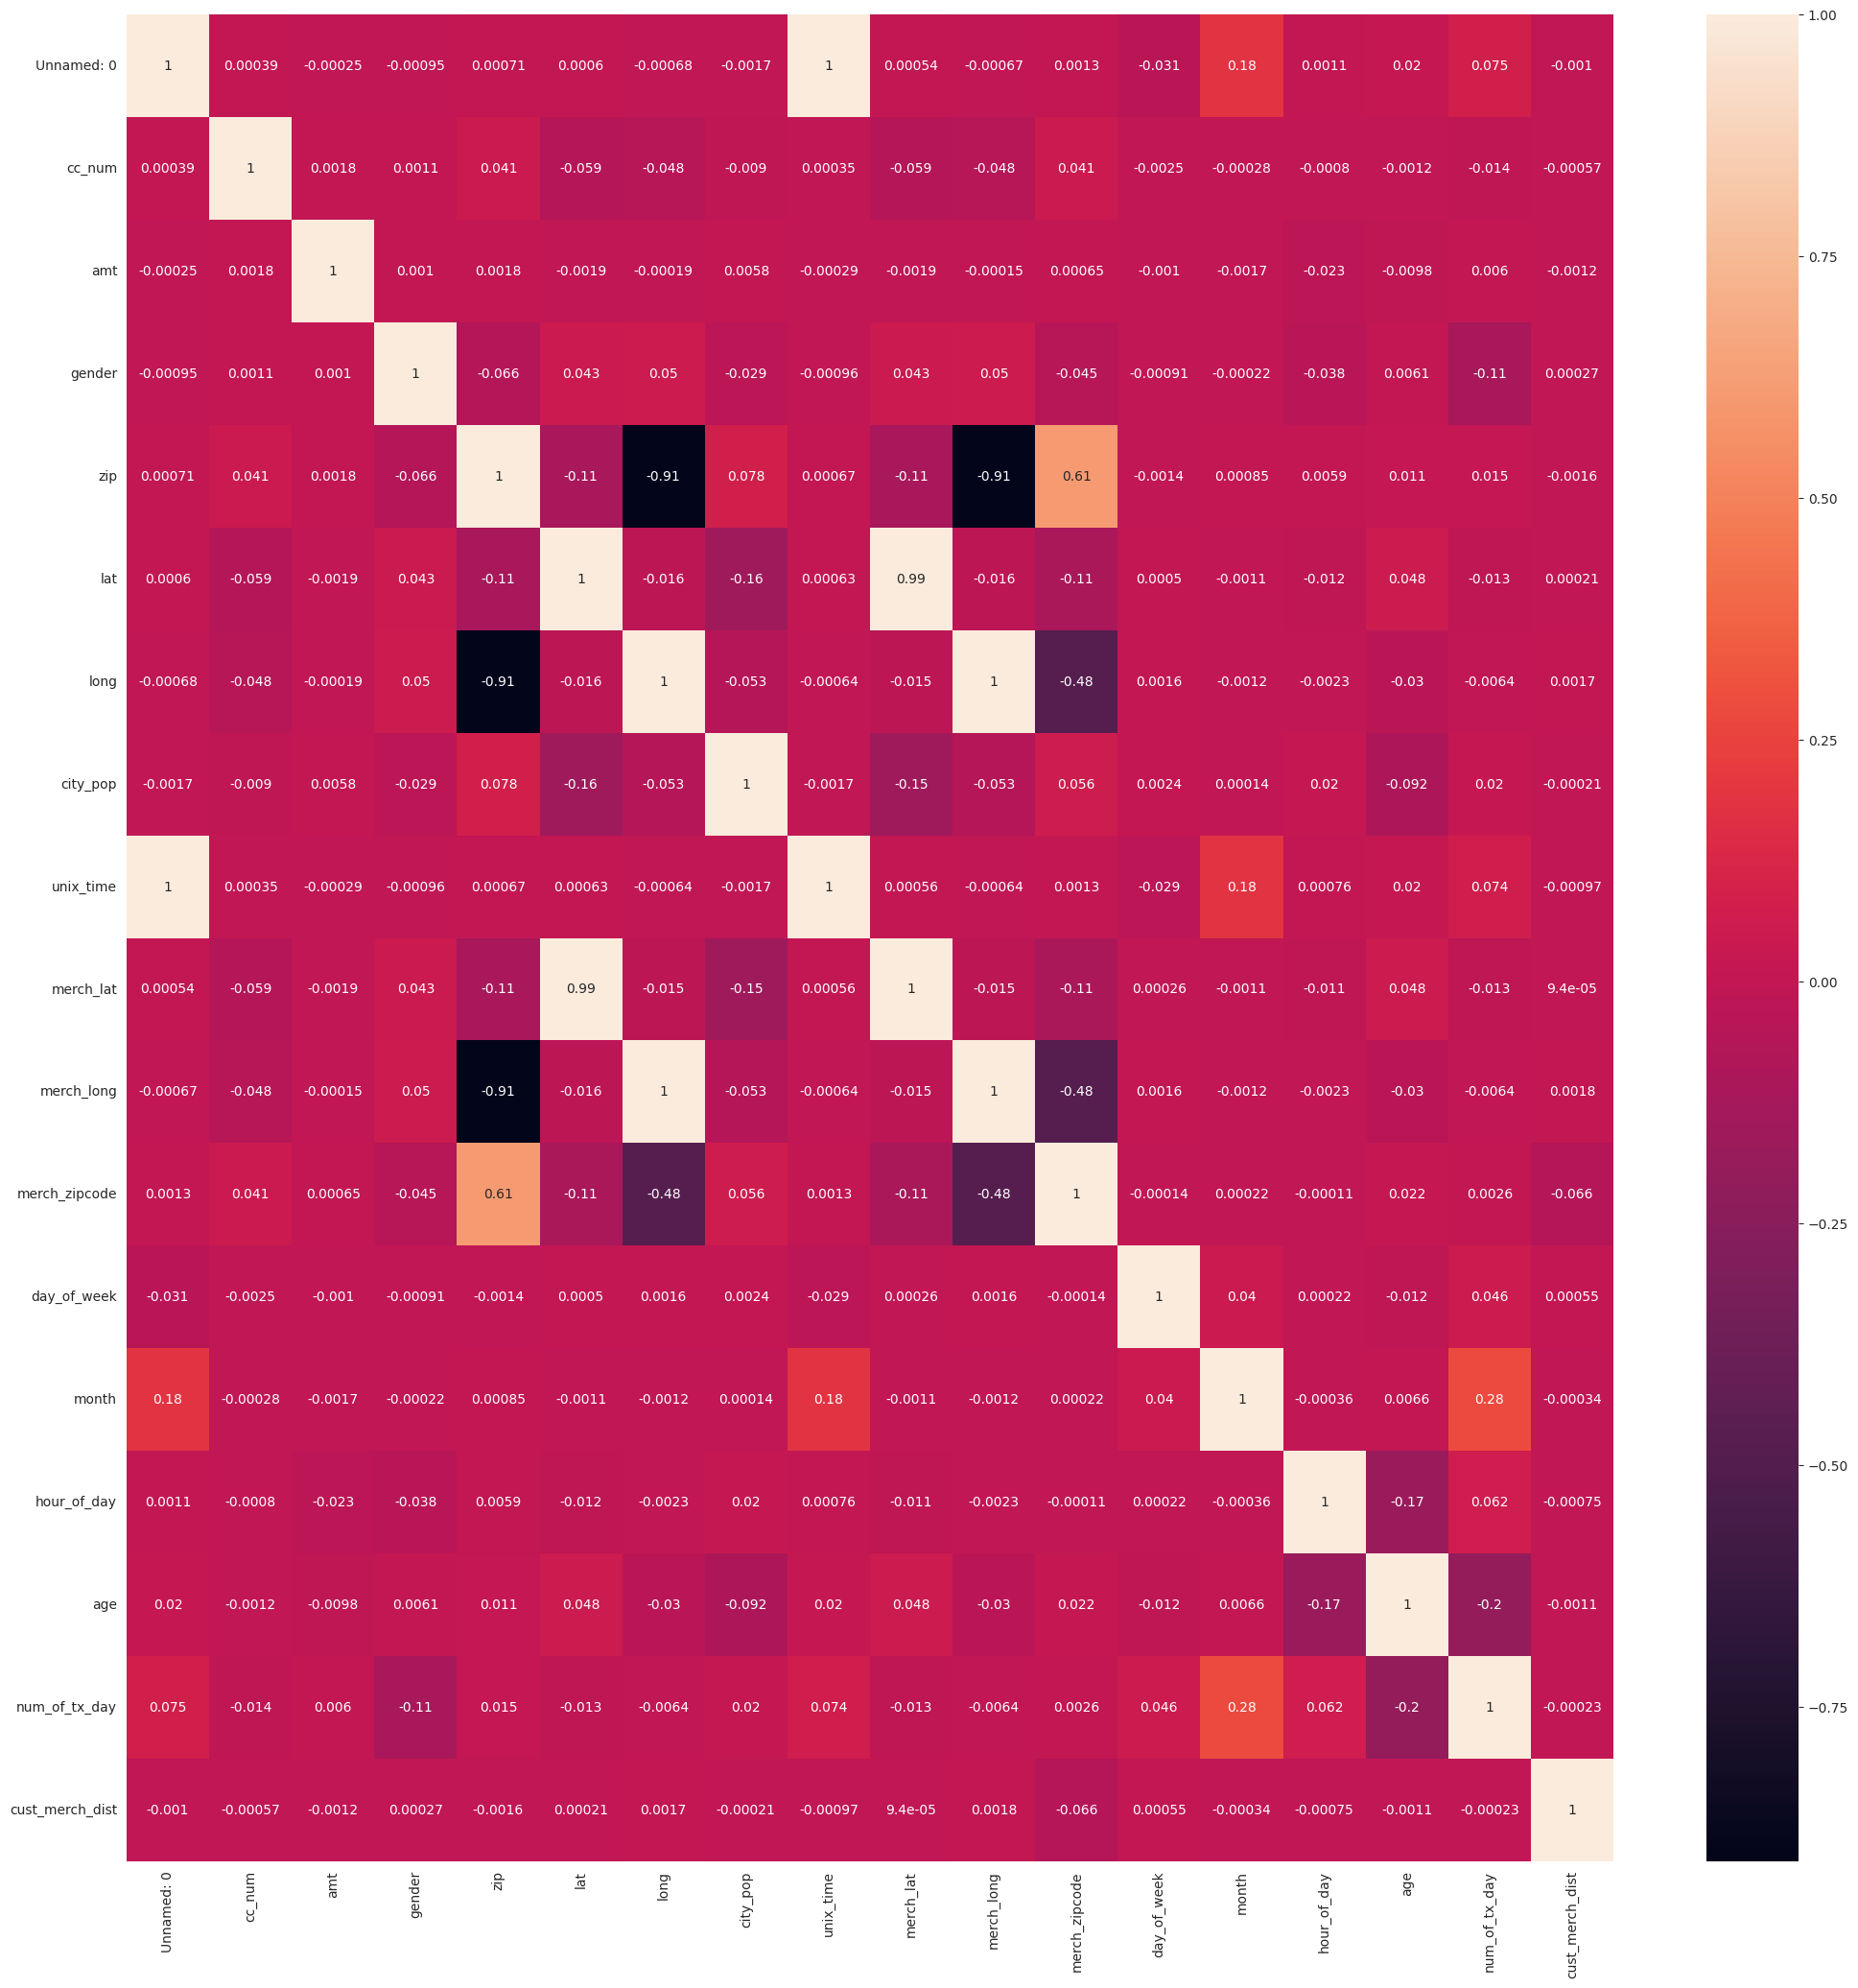

In [30]:
plt.figure(figsize=(25,25))
sns.heatmap(processed_data.corr(numeric_only=True),annot= True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target)
print(f'X train shape {X_train.shape}')
print(f'X test shape {X_test.shape}')
print(f'y train shape {y_train.shape}')
print(f'y test shape {y_test.shape}')

X train shape (1037340, 29)
X test shape (259335, 29)
y train shape (1037340,)
y test shape (259335,)


In [32]:


cat_col = ['cc_num','category','job', 'merchant','state']
# cat2_col = ['']
drop_col = ['Unnamed: 0','trans_num','first','last','dob',
            'street','city','zip', 'merch_zipcode'
            ,'lat','long','unix_time','merch_lat','merch_long', 'trans_date_trans_time']
scale_col = ['amt', 'city_pop','cust_merch_dist']
ct = ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_col),
        # ('cat', OneHotEncoder(sparse_output=False),cat_col),
        ('scale', StandardScaler(), scale_col),
        ('drop','drop',drop_col),
        ], remainder='passthrough')

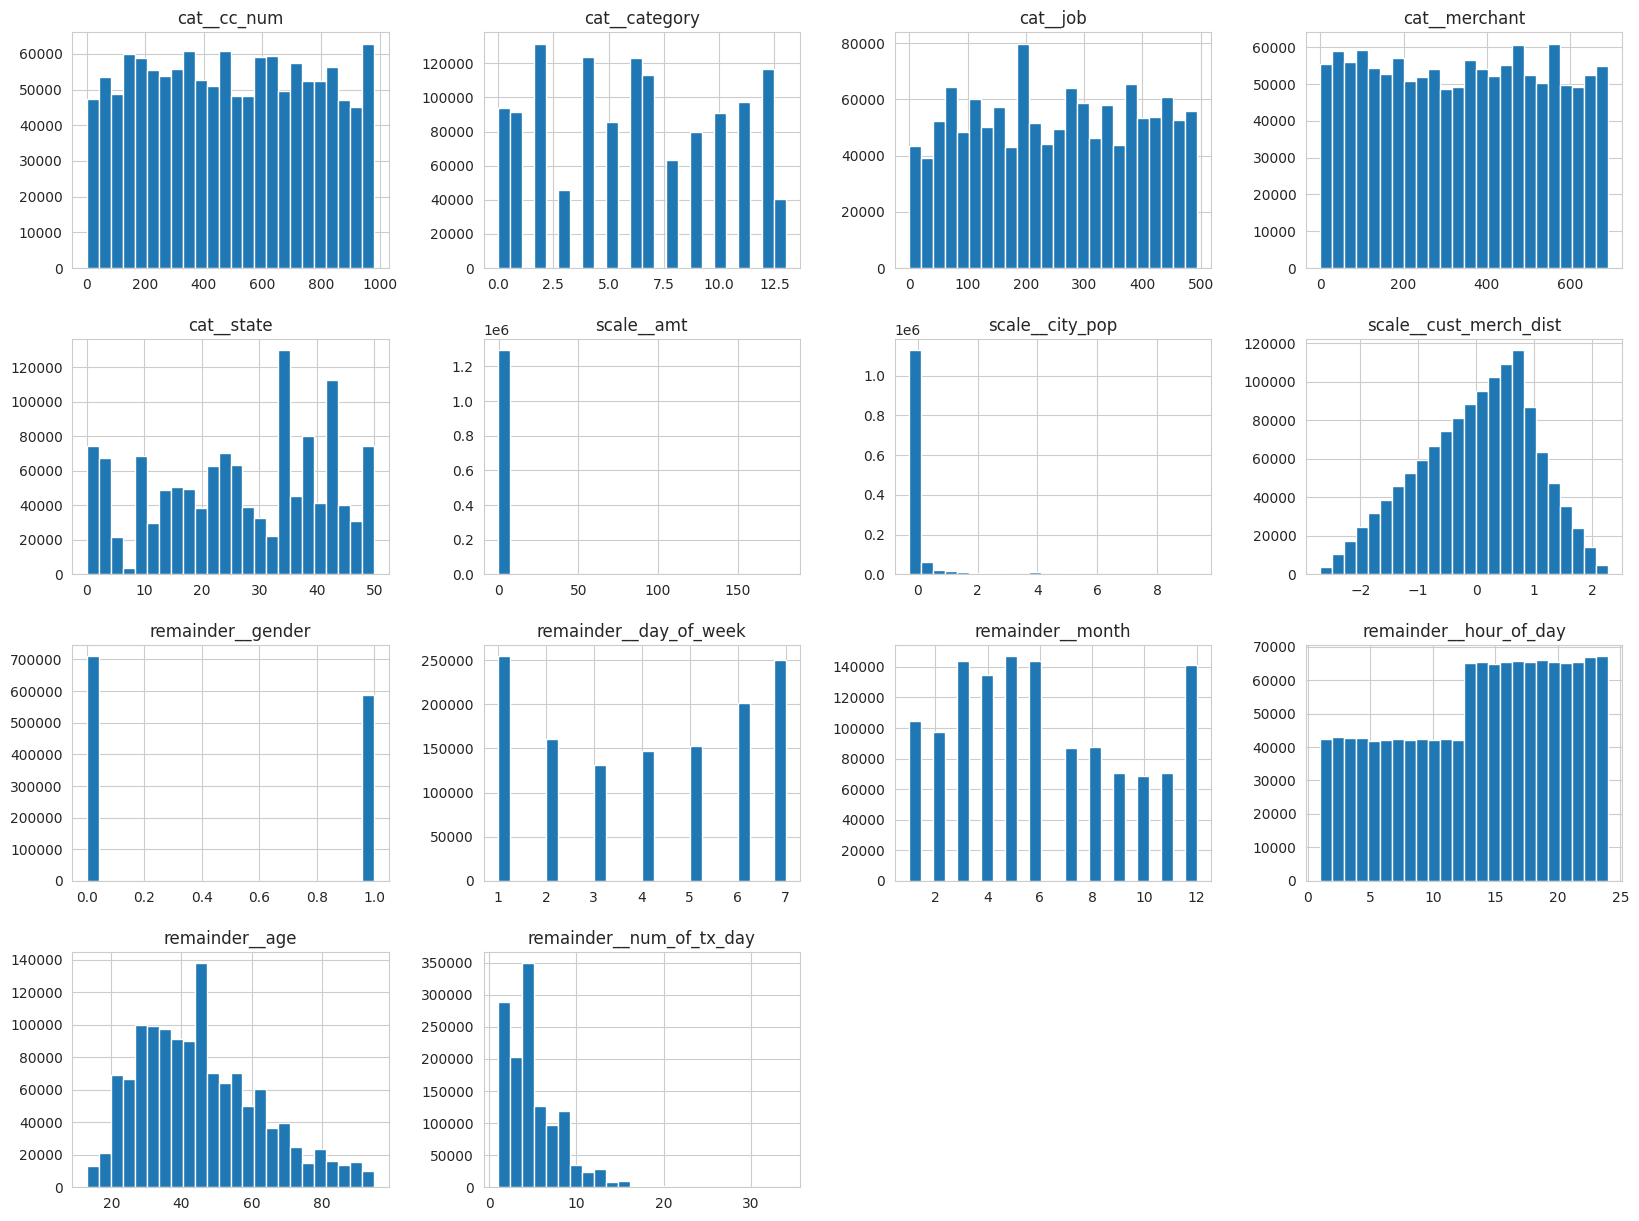

In [33]:
ct_processing = clone(ct)
ct_processing.set_output(transform='pandas')
ct_processing.fit_transform(processed_data).hist(bins=24, figsize=(20,15))
plt.show()

### GridSearch on 4 models with actual dataset

------------------------------LogisticRegrssion--------------------------------
Best Parameters: {'l1_ratio': 0, 'max_iter': 100}
LogisticRegrssion recall score is 0.00000
LogisticRegrssion precision score is 0.00000


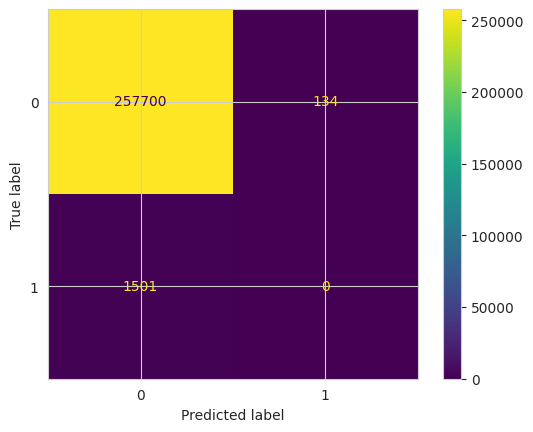

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335



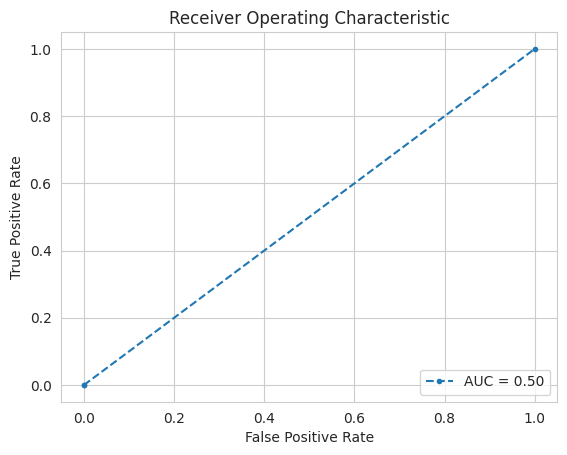

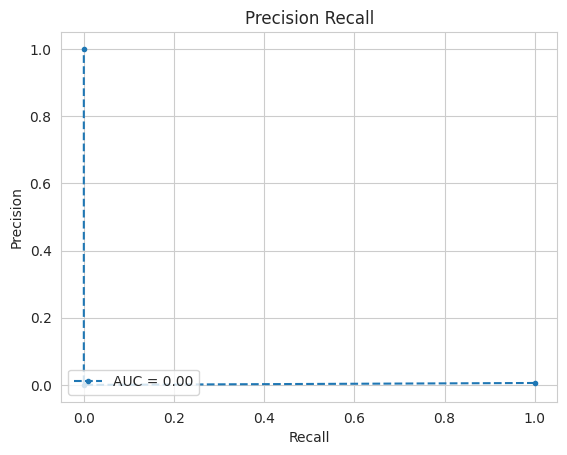

------------------------------HistGradBoost--------------------------------
Best Parameters: {'l2_regularization': 2, 'max_depth': 150, 'max_leaf_nodes': 100}
HistGradBoost recall score is 0.84810
HistGradBoost precision score is 0.97027


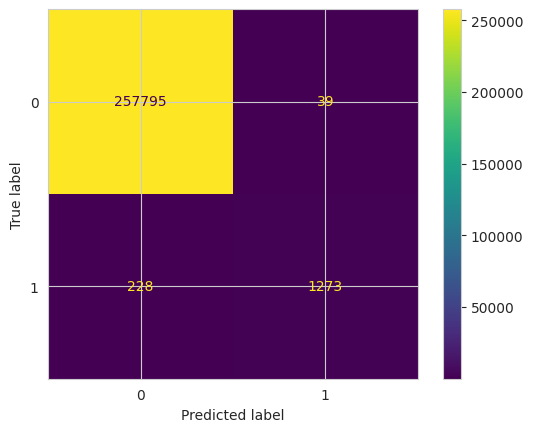

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.85      0.91      1501

    accuracy                           1.00    259335
   macro avg       0.98      0.92      0.95    259335
weighted avg       1.00      1.00      1.00    259335



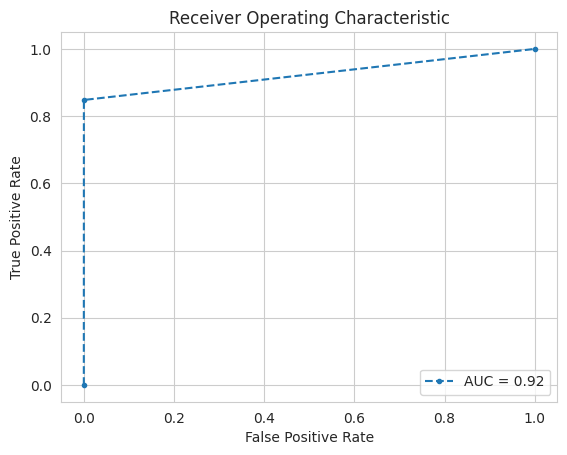

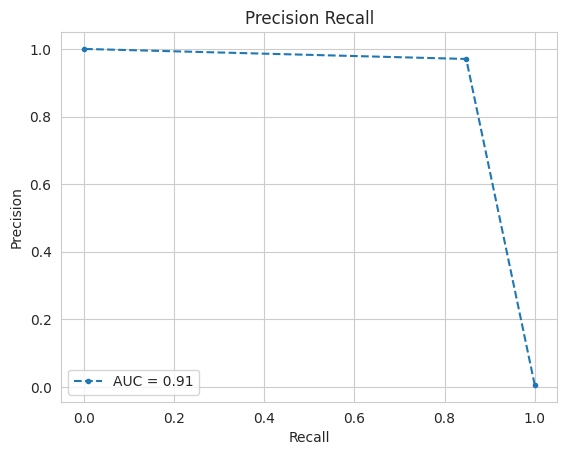

------------------------------XGBoost--------------------------------
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 15, 'subsample': 1.0}
XGBoost recall score is 0.92205
XGBoost precision score is 0.72613


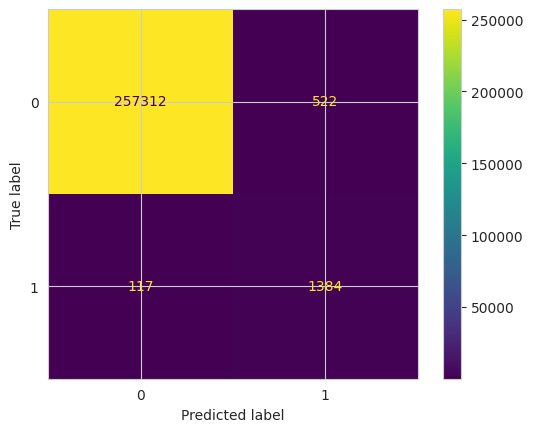

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.73      0.92      0.81      1501

    accuracy                           1.00    259335
   macro avg       0.86      0.96      0.91    259335
weighted avg       1.00      1.00      1.00    259335



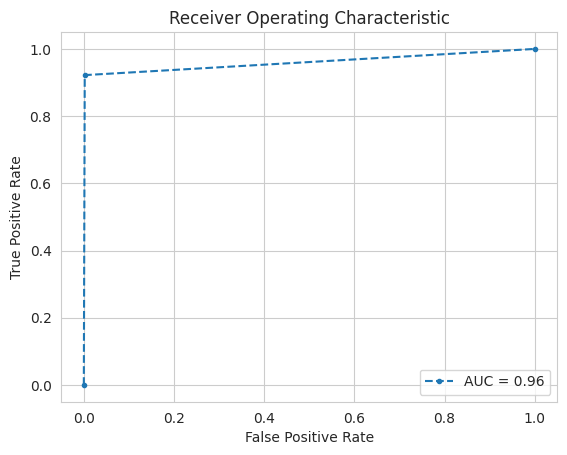

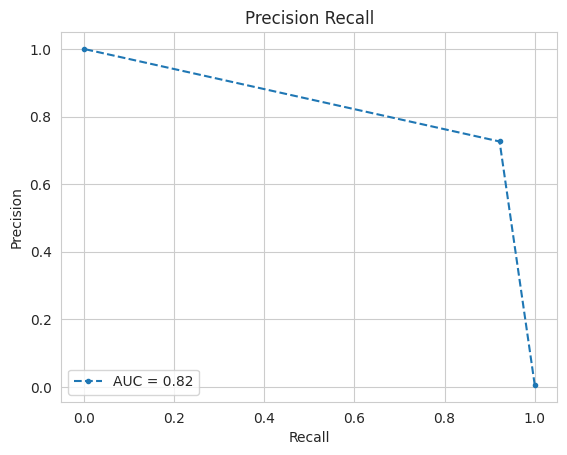

------------------------------SVM--------------------------------
Best Parameters: {'C': 0.1, 'max_iter': 500, 'tol': 0.0001}
SVM recall score is 0.00000
SVM precision score is 0.00000


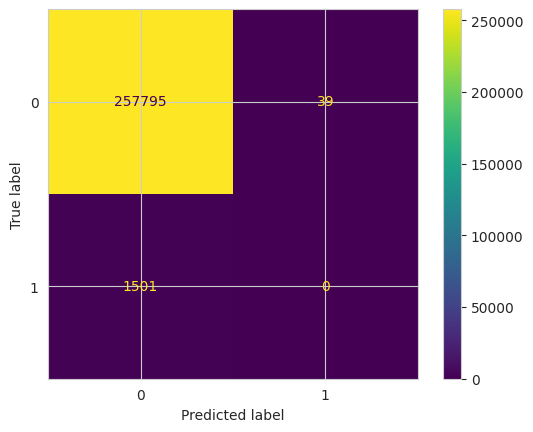

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335



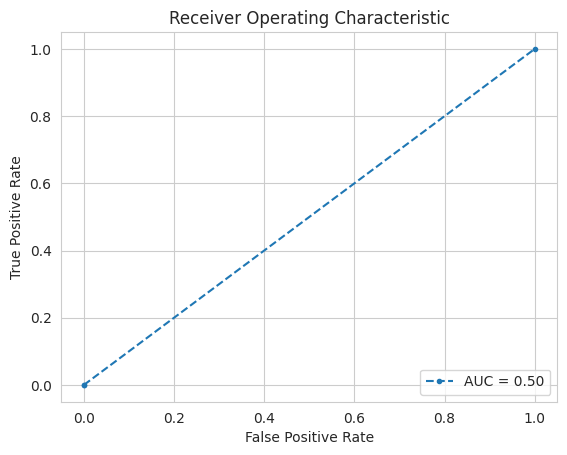

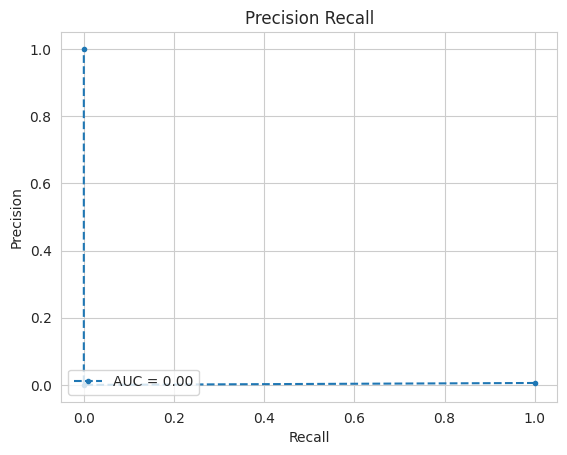

In [34]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=RANDOM_STATE)
models = [
    {'name':'LogisticRegrssion','model':LogisticRegression(penalty='elasticnet',solver='saga'),'params':{
        'l1_ratio':[0,0.25,0.5,0.75,1],
        'max_iter':[50,100,150]
    }},
    {'name':'HistGradBoost','model':HistGradientBoostingClassifier(),'params':{
        'max_leaf_nodes':[50,100,150],
        'max_depth':[50,100,150],
        'l2_regularization':[0.5,1,2]}},
    {'name':'XGBoost','model':xgb.XGBClassifier(booster='gbtree', tree_method="hist"),'params': {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'scale_pos_weight': [5,10,15]}},
    {'name':'SVM','model':LinearSVC(loss='hinge', random_state=RANDOM_STATE),'params':{
        'tol': [0.0001, 0.001, 0.01, 0.1],
        'C': [0.1, 0.5, 1],
        'max_iter':[500, 1000, 2000]
    }},
]

for model in models:

    print(f'------------------------------{model['name']}--------------------------------')
    # X_train_ct = ct.fit_transform(X_train)
    # X_test_ct = ct.fit_transform(X_test)

    pipe = Pipeline([
        ('ct',ct),
        ('gs', GridSearchCV(estimator=model['model'],param_grid=model['params'],cv=skf, scoring='recall'))
        ])

    train_pipe = clone(pipe)
    y_pred = train_pipe.fit(X_train,y_train).predict(X_test)
    # gs = GridSearchCV(estimator=model['model'],param_grid=model['params'],cv=skf)
    # y_pred = gs.fit(X_train_ct,y_train).predict(X_test_ct)
    print("Best Parameters:", train_pipe.named_steps['gs'].best_params_)
    print(f'{model['name']} recall score is {recall_score(y_true=y_test,y_pred=y_pred):0.5f}')
    print(f'{model['name']} precision score is {precision_score(y_true=y_test,y_pred=y_pred):0.5f}')
    conf_matrix = confusion_matrix(y_true=y_test,y_pred = y_pred)
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.show()

    class_report = classification_report(y_test,y_pred)
    print(class_report)

    fpr, tpr, ftthresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '.--', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    prec, recall, prthresholds = precision_recall_curve(y_test,y_pred)
    pr_auc = auc(recall,prec)
    plt.title('Precision Recall')
    plt.plot(recall, prec, '.--',label = 'AUC = %0.2f' % pr_auc)
    plt.legend(loc = 'lower left')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

### Retraining the best models on an oversampled dataset

------------------------------HistGradBoost--------------------------------
HistGradBoost recall score is 0.81546
HistGradBoost precision score is 0.85955


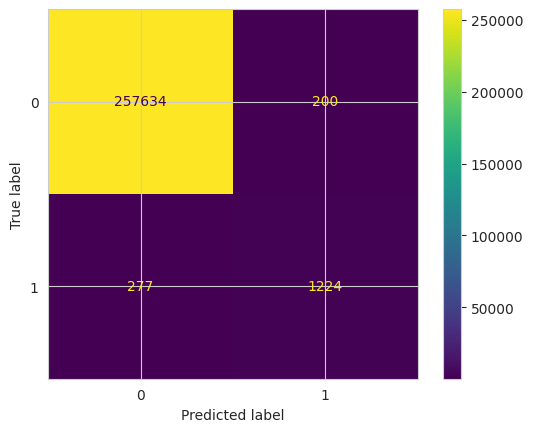

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.86      0.82      0.84      1501

    accuracy                           1.00    259335
   macro avg       0.93      0.91      0.92    259335
weighted avg       1.00      1.00      1.00    259335



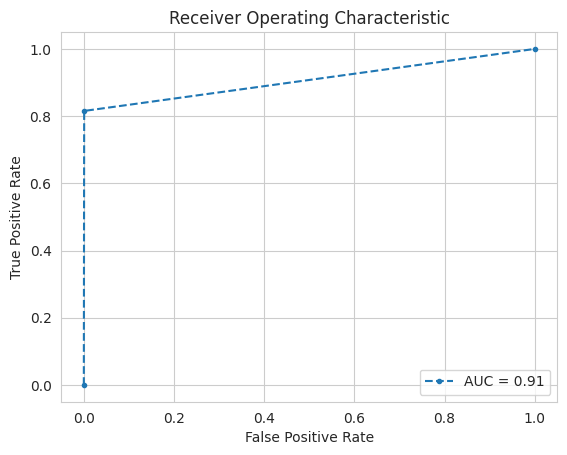

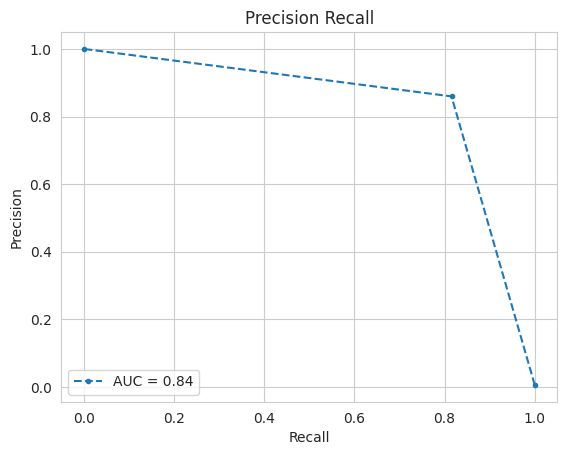

------------------------------XGBoost--------------------------------
XGBoost recall score is 0.85809
XGBoost precision score is 0.03646


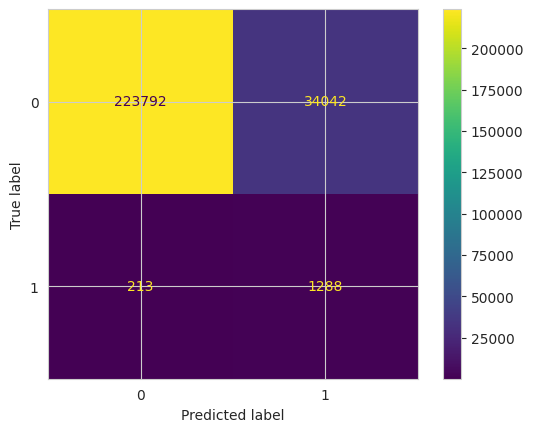

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    257834
           1       0.04      0.86      0.07      1501

    accuracy                           0.87    259335
   macro avg       0.52      0.86      0.50    259335
weighted avg       0.99      0.87      0.92    259335



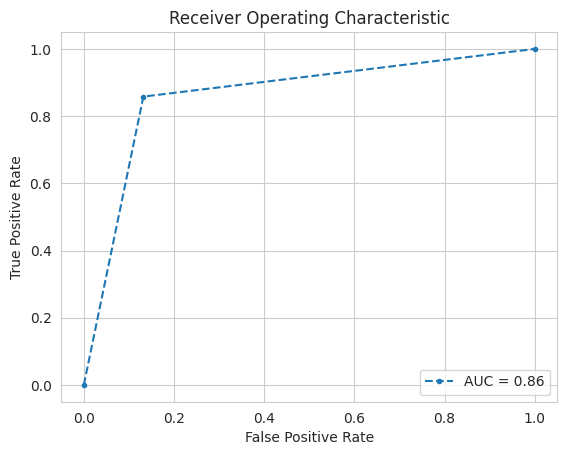

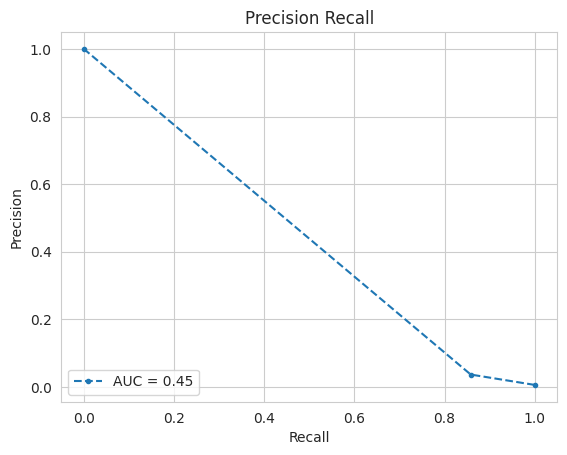

In [35]:
X_train_ct = ct.fit_transform(X_train,y_train)
X_test_ct = ct.fit_transform(X_test,y_test)
sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')
X_train_res, y_train_res = sm.fit_resample(X_train_ct, y_train)

#BEST PARAMS
#HISTGRADBOOST: {'l2_regularization': 2, 'max_depth': 150, 'max_leaf_nodes': 100}
#XGBOOST: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 15, 'subsample': 1.0}

models = [
    {'name':'HistGradBoost','model':HistGradientBoostingClassifier(l2_regularization=2, max_depth=150, max_leaf_nodes= 150)},
    {'name':'XGBoost','model':xgb.XGBClassifier(booster='gbtree', tree_method="hist", colsample_bytree=0,
                                                gamma= 0.5, max_depth= 5, min_child_weight= 5, scale_pos_weight= 15, subsample= 1.0)},
]

for model in models:

    print(f'------------------------------{model['name']}--------------------------------')

    #pipeline is not needed since ct is done
    # pipe = Pipeline([
    #     ('ct',ct),
    #     ('mod', model['model'])
    #     ])

    # train_pipe = clone(pipe)
    # y_pred = train_pipe.fit(X_train_res,y_train_res).predict(X_test)

    y_pred = model['model'].fit(X_train_res,y_train_res).predict(X_test_ct)
    print(f'{model['name']} recall score is {recall_score(y_true=y_test,y_pred=y_pred):0.5f}')
    print(f'{model['name']} precision score is {precision_score(y_true=y_test,y_pred=y_pred):0.5f}')

    conf_matrix = confusion_matrix(y_true=y_test,y_pred = y_pred)
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.show()

    class_report = classification_report(y_test,y_pred)
    print(class_report)

    fpr, tpr, ftthresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '.--', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    prec, recall, prthresholds = precision_recall_curve(y_test,y_pred)
    pr_auc = auc(recall,prec)
    plt.title('Precision Recall')
    plt.plot(recall, prec, '.--',label = 'AUC = %0.2f' % pr_auc)
    plt.legend(loc = 'lower left')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
LightGBM recall score is 0.93604
LightGBM precision score is 0.13131


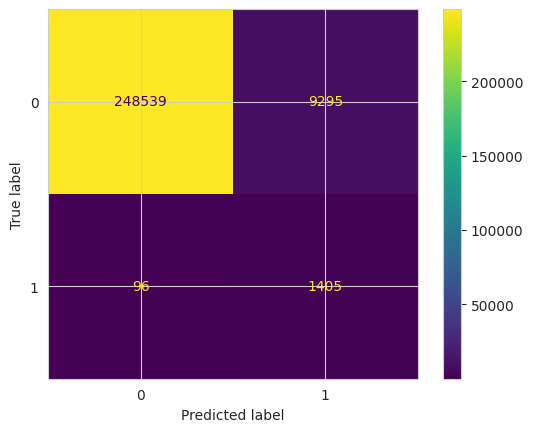

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    257834
           1       0.13      0.94      0.23      1501

    accuracy                           0.96    259335
   macro avg       0.57      0.95      0.61    259335
weighted avg       0.99      0.96      0.98    259335



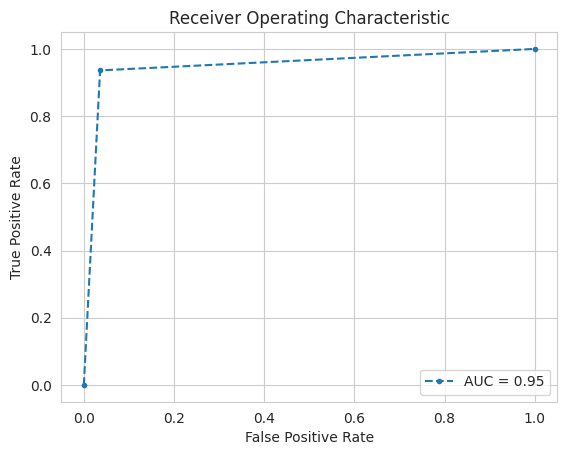

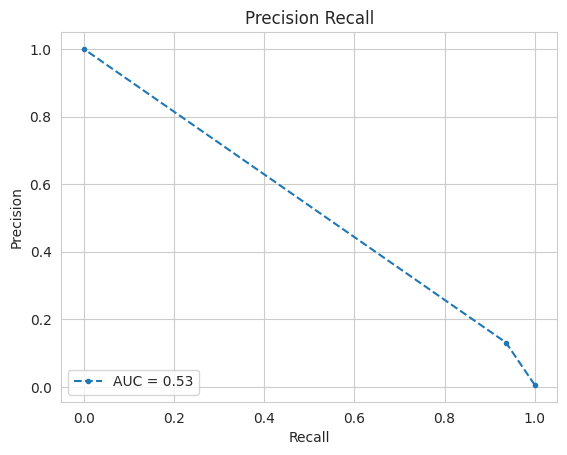

In [37]:
import lightgbm as lgb


pipegbm = Pipeline([
        ('ct',ct),
        ('gbm', lgb.LGBMClassifier(n_jobs=-1,is_unbalance=True))
        ])


y_pred = pipegbm.fit(X_train,y_train).predict(X_test)
print(f'LightGBM recall score is {recall_score(y_true=y_test,y_pred=y_pred):0.5f}')
print(f'LightGBM precision score is {precision_score(y_true=y_test,y_pred=y_pred):0.5f}')

conf_matrix = confusion_matrix(y_true=y_test,y_pred = y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

class_report = classification_report(y_test,y_pred)
print(class_report)

fpr, tpr, ftthresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '.--', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prec, recall, prthresholds = precision_recall_curve(y_test,y_pred)
pr_auc = auc(recall,prec)
plt.title('Precision Recall')
plt.plot(recall, prec, '.--',label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


### Training oversampled data on LinearSVC

SVC recall score is 0.84011
SVC precision score is 0.01518


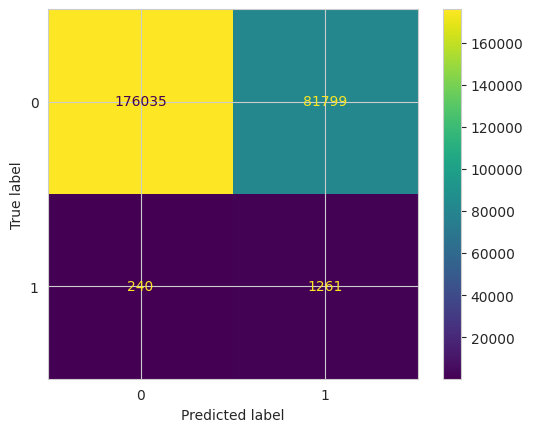

              precision    recall  f1-score   support

           0       1.00      0.68      0.81    257834
           1       0.02      0.84      0.03      1501

    accuracy                           0.68    259335
   macro avg       0.51      0.76      0.42    259335
weighted avg       0.99      0.68      0.81    259335



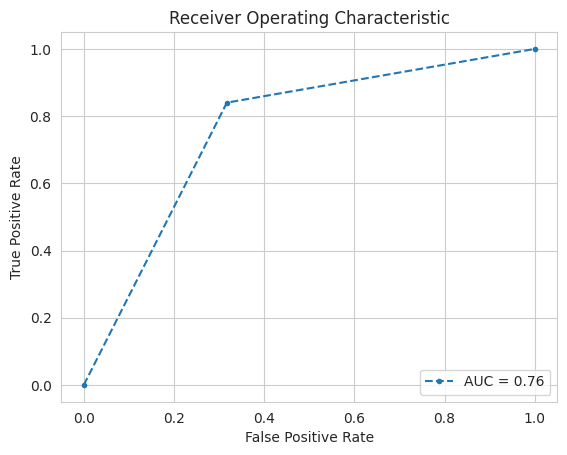

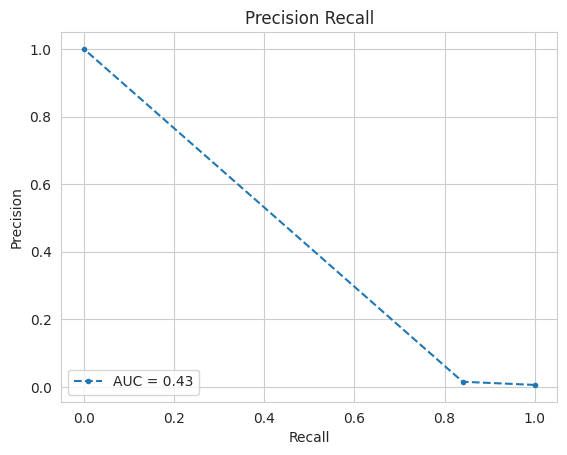

In [ ]:

X_train_ct = ct.fit_transform(X_train,y_train)
X_test_ct = ct.fit_transform(X_test,y_test)
sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')
X_train_res, y_train_res = sm.fit_resample(X_train_ct, y_train)

lsvc = LinearSVC(loss='hinge', random_state=42)
y_pred = lsvc.fit(X_train_res,y_train_res).predict(X_test_ct)
print(f'SVC recall score is {recall_score(y_true=y_test,y_pred=y_pred):0.5f}')
print(f'SVC precision score is {precision_score(y_true=y_test,y_pred=y_pred):0.5f}')

conf_matrix = confusion_matrix(y_true=y_test,y_pred = y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

class_report = classification_report(y_test,y_pred)
print(class_report)

fpr, tpr, ftthresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '.--', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prec, recall, prthresholds = precision_recall_curve(y_test,y_pred)
pr_auc = auc(recall,prec)
plt.title('Precision Recall')
plt.plot(recall, prec, '.--',label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
